In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.metrics import  mean_squared_error

import pickle

In [2]:
%matplotlib inline

In [3]:
def adf_test(feature,series, threshold=0.05):
    for feat in feature:
        #print('feature:  ',x,'p_value    ',adf_test(df_train[x]))    
        dftest = adfuller(series[feat], autolag='AIC')
        #print('dftest  ',dftest)
        #dftest[1] is p-value 
        p_value = dftest[1]
        print('feature:  ',feat,'p_value    ',p_value)    

In [4]:
def check_timestamp_irreg(df_input):
    time_diff = df_input.index.to_series().diff()
    print(time_diff)
    max_diff = time_diff.max()
    min_diff = time_diff.min()
    mean_diff = time_diff.mean()
    median_diff = time_diff.median()
    
    # Print the results
    print(f"Max difference: {max_diff}")
    print(f"Min difference: {min_diff}")
    print(f"Mean difference: {mean_diff}")
    print(f"Median difference: {median_diff}")
    return time_diff

In [5]:
def resampling_interpolation(df_input):
    df_resampled = df_input.resample('50L').mean()  # 'S' stands for second intervals
    
    df_resampled = df_resampled.interpolate(method='linear')

    return df_resampled

In [6]:
def data_normalization(df_input,mode,scaler):
    if mode=='fit':
        df_scaled = pd.DataFrame(scaler.fit_transform(df_input), columns=df_input.columns, index=df_input.index)
    elif mode=='transform':
        df_scaled = pd.DataFrame(scaler.transform(df_input), columns=df_input.columns, index=df_input.index)
    return df_scaled,scaler

In [7]:
def preprocess_df(df,feature):
    
    df['timestamp'] = df['timestamp'] / 1e9  # Convert from nanoseconds to seconds
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)

    df_diff = df.copy()

    df_diff.dropna(inplace=True)

    time_diff = check_timestamp_irreg(df)
    time_diff = time_diff.dropna()
    print(time_diff)
    plt.figure(figsize=(10, 5))
    time_diff.plot(kind='bar')
    plt.ylabel('Time Difference')
    plt.title('Time Gaps Between Consecutive Timestamps')
    #plt.show()
    
    data_resampl=resampling_interpolation(df)
    check_timestamp_irreg(data_resampl)
    return data_resampl

In [8]:
# Fit the VAR model using success data
def check_optimal_lag(df_train_norm,feature,maxlags = 40):
    
    aic_vals = []
    for lag in range(1, maxlags + 1):
        model = VAR(df_train_norm[feature])
        result = model.fit(lag)
        aic_vals.append(result.aic)
       
    lags = list(range(1, maxlags + 1))
    
    plt.figure(figsize=(10, 2))
    plt.plot(lags, aic_vals, label='AIC',color='blue')
    
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.xlim(left=0)
    plt.xlabel('Lag order')
    plt.ylabel('AIC')
    plt.title('Lag order selection')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [9]:
def predict_with_var_model(best_model, lag_order, test_data):
    
    predictions = best_model.forecast(y=test_data.values[:lag_order], steps=len(test_data))
    predicted_df = pd.DataFrame(predictions, index=test_data.index, columns=test_data.columns)
    
    return predicted_df

In [10]:
def calculate_residual(error_data,range_num):
    sum_residual = error_data.copy(deep=True)

    for k in range(len(error_data)-range_num):
        sum_residual.iloc[k]=np.sum(error_data.iloc[k:k + range_num])
    sum_residual = sum_residual.shift(periods=range_num, axis=0).dropna()
    return sum_residual

In [11]:
def main_calculation(feature,data):
    df_data = pd.read_csv(data)
    df_data_resampl=preprocess_df(df_data,feature)
    return df_data_resampl

In [12]:
def show_data(data_frame,feature):
    for feat in feature:
        plt.figure(figsize=(10, 2))
        data_frame[feat].plot(color='blue')
        plt.title(f'{feat}')
        plt.grid(True)
        plt.show()

# Granger Causality Test

In [13]:
#Granger causality test to determine variable relevance
#https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2
def granger_causality_matrix(df_data, feature, maxlag=40):
    result = pd.DataFrame(np.zeros((len(feature), len(feature))), columns=feature, index=feature)
    df_data=df_data.drop('success', axis=1)
    for c in result.columns:
        for r in result.index:
            if r != c:  # Avoid testing a variable against itself
                test_result = grangercausalitytests(df_data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test[0]['ssr_chi2test'][1], 4) for test in test_result.values()]
                min_p_value = np.min(p_values)
                result.loc[r, c] = min_p_value
    result.columns = [var + '_x' for var in feature]
    result.index = [var + '_y' for var in feature]
    return result

In [14]:
def training(df_train,df_test,selected_features,lag):
    train = df_train[selected_features]
    test = df_test[selected_features]
    model = VAR(train)
    model_fit = model.fit(lag)
    return model_fit

In [15]:
#form coefficient matrix
def form_coeff(model_fit,selected_features,lag):
    coeff_mat=np.array([])
    for i in range(len(selected_features)):
        #for lag=2
        curr_feature=np.concatenate((model_fit.coefs[0][i], model_fit.coefs[1][i]), axis=0)
        coeff_mat=np.hstack((coeff_mat,curr_feature))
    coeff_mat=np.reshape(coeff_mat,(len(selected_features),lag*len(selected_features))).T
    return coeff_mat

#form data matrix
def form_data(selected_features,lag):
    data_mat=np.array([])
    for i in range(test_size-lag):
        curr_col=np.concatenate((df_test.iloc[i+1][selected_features],df_test.iloc[i][selected_features]),axis=0)
        data_mat=np.concatenate((data_mat,curr_col),axis=0)
    data_mat=np.reshape(data_mat,(test_size-lag,lag*len(selected_features)))
    return data_mat

### Main Operation

timestamp
2014-10-15 17:41:26.605760098                         NaT
2014-10-15 17:41:26.655759811   0 days 00:00:00.049999713
2014-10-15 17:41:26.705760002   0 days 00:00:00.050000191
2014-10-15 17:41:26.755760193   0 days 00:00:00.050000191
2014-10-15 17:41:26.805759907   0 days 00:00:00.049999714
                                           ...           
2014-10-15 17:43:15.905760050   0 days 00:00:00.100000143
2014-10-15 17:43:16.005759954   0 days 00:00:00.099999904
2014-10-15 17:43:16.105760098   0 days 00:00:00.100000144
2014-10-15 17:43:16.205760002   0 days 00:00:00.099999904
2014-10-15 17:43:16.305759907   0 days 00:00:00.099999905
Name: timestamp, Length: 1801, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.100000382
Min difference: 0 days 00:00:00.049999713
Mean difference: 0 days 00:00:00.060944444
Median difference: 0 days 00:00:00.050000189
timestamp
2014-10-15 17:41:26.655759811   0 days 00:00:00.049999713
2014-10-15 17:41:26.705760002   0 days 00:00:00.050000191


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2687876066.py:2: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('50L').mean()  # 'S' stands for second intervals


timestamp
2014-10-15 17:41:26.600                      NaT
2014-10-15 17:41:26.650   0 days 00:00:00.050000
2014-10-15 17:41:26.700   0 days 00:00:00.050000
2014-10-15 17:41:26.750   0 days 00:00:00.050000
2014-10-15 17:41:26.800   0 days 00:00:00.050000
                                   ...          
2014-10-15 17:43:16.100   0 days 00:00:00.050000
2014-10-15 17:43:16.150   0 days 00:00:00.050000
2014-10-15 17:43:16.200   0 days 00:00:00.050000
2014-10-15 17:43:16.250   0 days 00:00:00.050000
2014-10-15 17:43:16.300   0 days 00:00:00.050000
Freq: 50ms, Name: timestamp, Length: 2195, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.050000
Min difference: 0 days 00:00:00.050000
Mean difference: 0 days 00:00:00.050000
Median difference: 0 days 00:00:00.050000


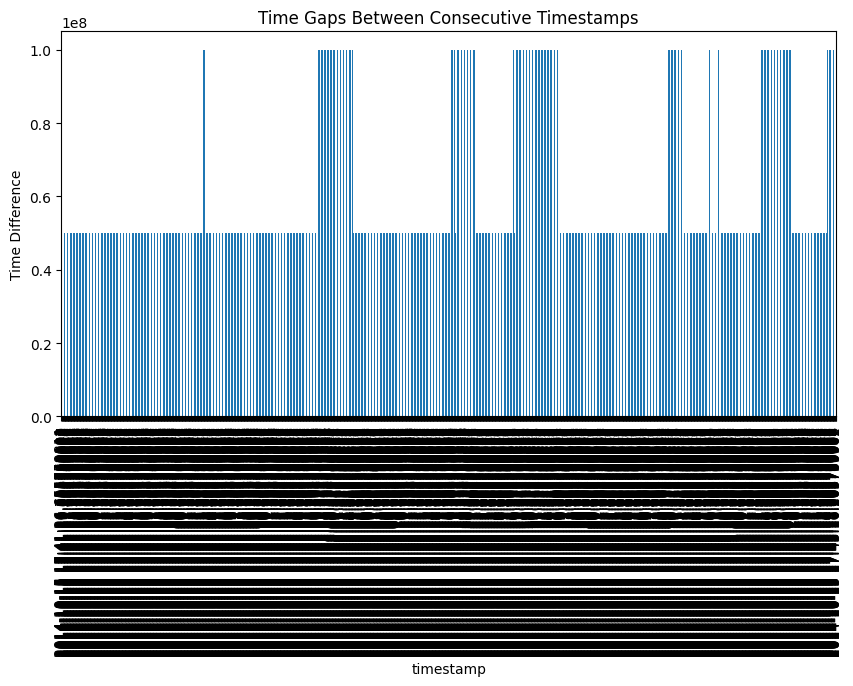

In [16]:
all_features=['laplacian_variance', 'entropy', 'brightness', 'contrast','disparity_mean','disparity_var','disparity_std','v_x','d_vx','v_y','d_vy','v_z','d_vz','v','d_v','a_x','d_ax','a_y','d_ay','a_z','d_az','a','d_a','w_x','d_wx','w_y','d_wy','w_z','d_wz','w','d_w','success']
df=main_calculation(all_features,'features_v203_openvslam_train-test_abs_range.csv')

In [17]:
split_idx=600
df_train_resampl=df.head(split_idx)
df_test_resampl=df.iloc[split_idx:]
scaler = MinMaxScaler()
df_train,scaler=data_normalization(df_train_resampl,'fit',scaler)
df_test,scaler=data_normalization(df_test_resampl,'transform',scaler)
train_size = len(df_train)
test_size=len(df_test)

In [ ]:
granger_result=granger_causality_matrix(df_train, all_features[:-1], maxlag=10)
#granger_result.to_excel('granger_result.xlsx', index=True)

c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  

In [19]:
adf_test(all_features[:-1],df_train)

feature:   laplacian_variance p_value     0.08967830347447286
feature:   entropy p_value     0.003835923203092575
feature:   brightness p_value     0.18591089225919677
feature:   contrast p_value     0.23410900428658438
feature:   disparity_mean p_value     0.03770218989113663
feature:   disparity_var p_value     0.013404399382502843
feature:   disparity_std p_value     0.010655661297661904
feature:   v_x p_value     0.0017639248382225945
feature:   d_vx p_value     1.1527168125587294e-06
feature:   v_y p_value     0.0003399904821422196
feature:   d_vy p_value     0.00322621004015002
feature:   v_z p_value     9.046144618739699e-11
feature:   d_vz p_value     7.541405636965838e-16
feature:   v p_value     0.0017322078148129878
feature:   d_v p_value     1.1049069331131868e-05
feature:   a_x p_value     1.1791792321269464e-15
feature:   d_ax p_value     2.0435886773506528e-30
feature:   a_y p_value     7.340199805283378e-21
feature:   d_ay p_value     1.2787768331410953e-17
feature:   a

In [20]:
selected_features_1=['laplacian_variance', 'entropy', 'brightness', 'contrast','disparity_mean','disparity_std','v_x','d_vx','v_y','d_vy','v','d_v','d_wx','w_y','d_wy','d_wz','w','d_w']
feature_curr=selected_features_1

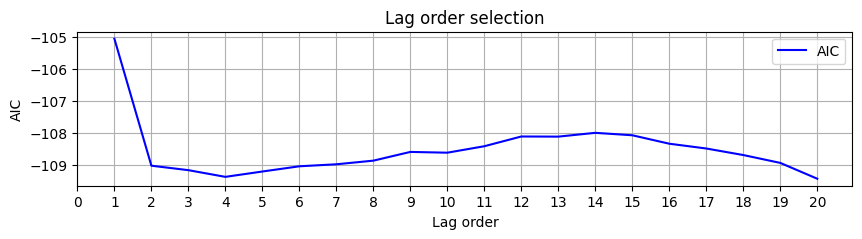

In [21]:
check_optimal_lag(df_train,feature_curr,maxlags = 20)

Select lag_order at the elbow of the graph; lag_order=2 

In [22]:
num_lag=2
model_curr=training(df_train,df_test,feature_curr,num_lag)

Calculate the prediction by multiplying coefficient matrix to data matrix then adding with intercept

In [31]:
#save the model
file_name='autovar.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(model_curr, file)

In [23]:
coeff_mat=form_coeff(model_curr,feature_curr,num_lag)
data_mat=form_data(feature_curr,num_lag)

print("coeff matrix dimension:   ",coeff_mat.shape)
print("data matrix dimension:   ",data_mat.shape)

multi_mat=np.matmul(data_mat,coeff_mat)
predicted_mat=multi_mat+model_curr.intercept

predicted_df_bf = pd.DataFrame(predicted_mat)

df_predicted = pd.DataFrame(0, index=df_test.index,columns=feature_curr)
df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
df_predicted=df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :]

coeff matrix dimension:    (36, 18)
data matrix dimension:    (1593, 36)


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2319138345.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.12493229 0.10365063 0.22784302 ... 0.51690395 0.37828705 0.38818677]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2319138345.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.76252893 0.70111055 0.82992338 ... 0.7781231  0.85802829 0.86993813]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2319138345.py:13: FutureWarning: Setting an item of incompatible dt

laplacian_variance     mse  0.005338943371244985


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


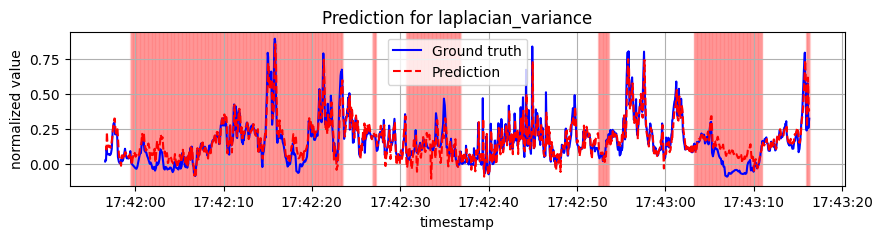

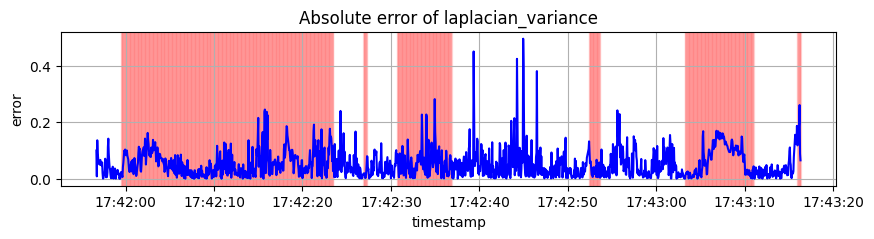

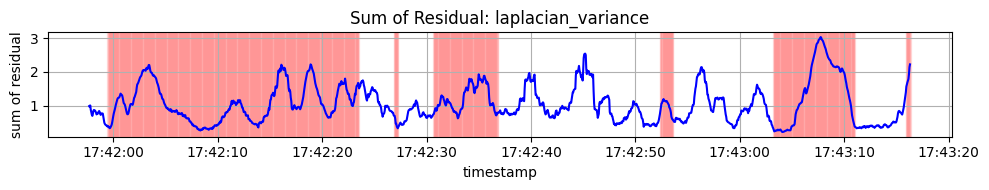

entropy     mse  0.0036985391107283343


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


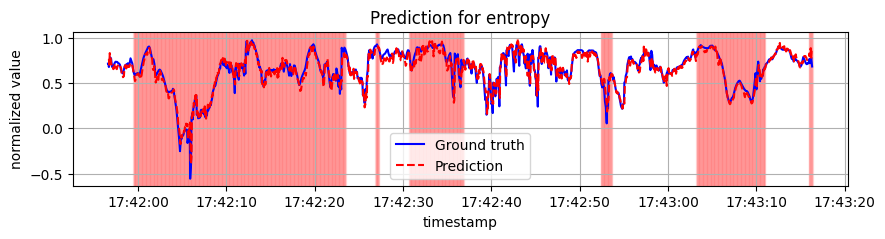

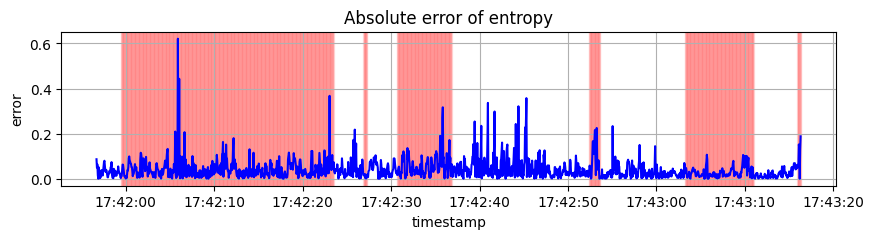

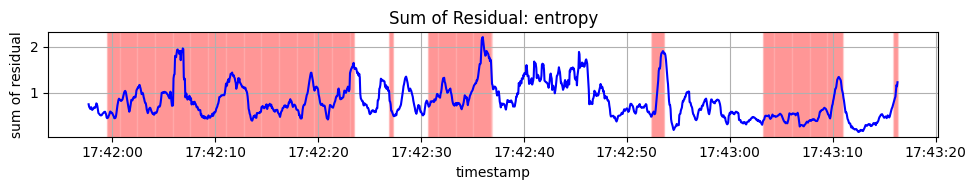

brightness     mse  0.0070795011336256194


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


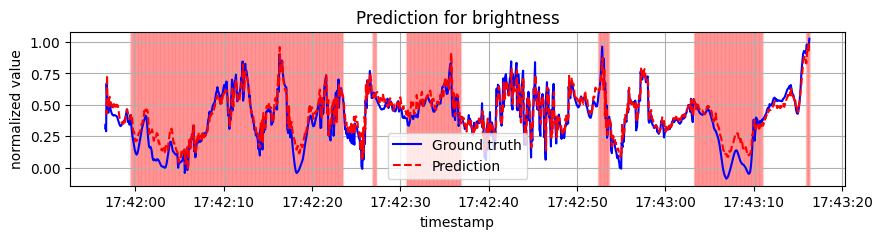

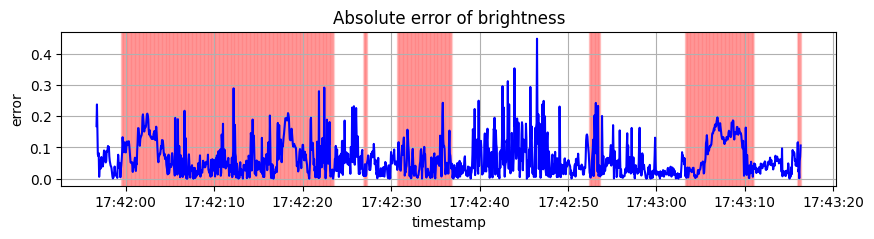

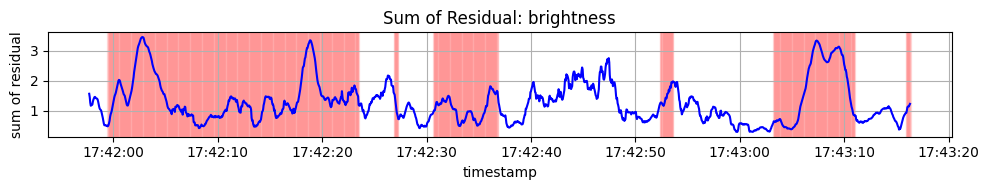

contrast     mse  0.00817369057061221


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


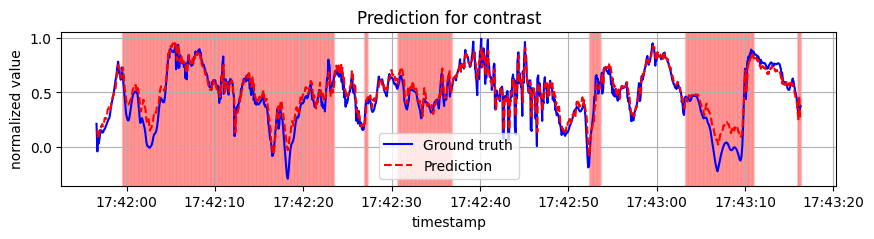

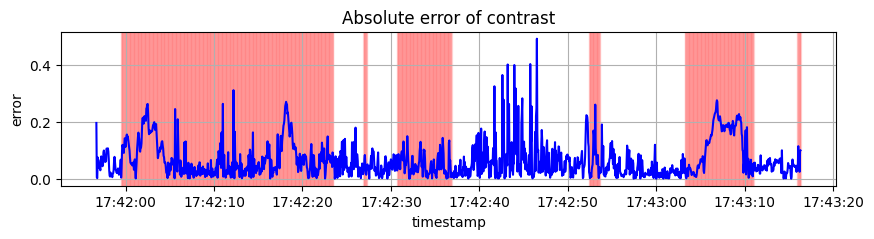

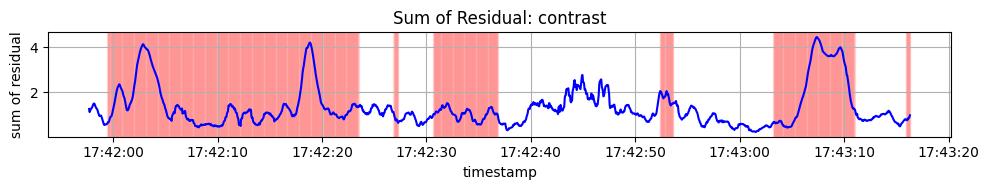

disparity_mean     mse  0.0012160415936650114


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


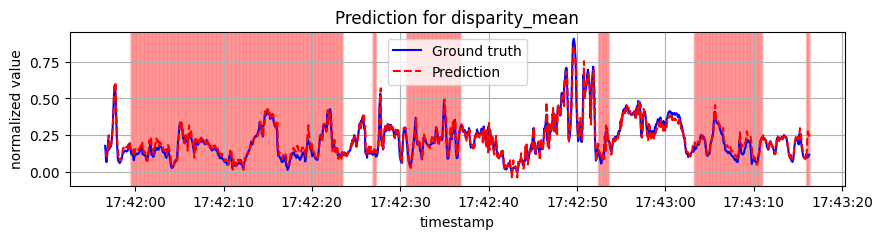

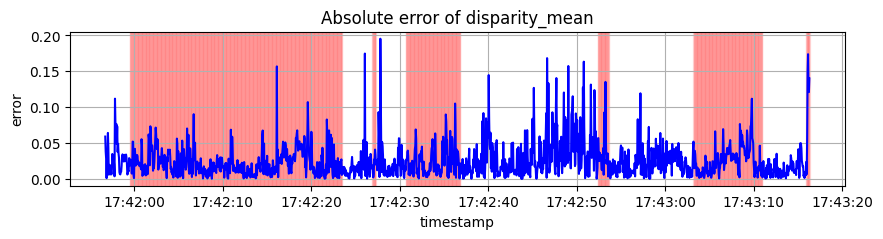

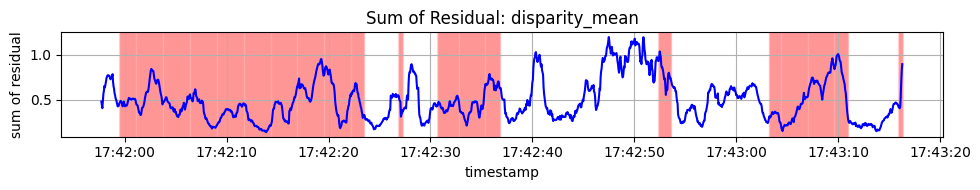

disparity_std     mse  0.0025079937739029704


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


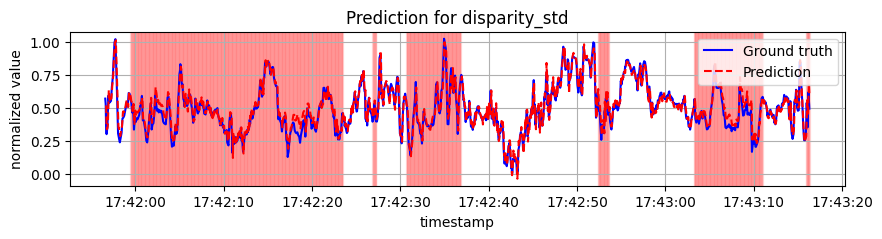

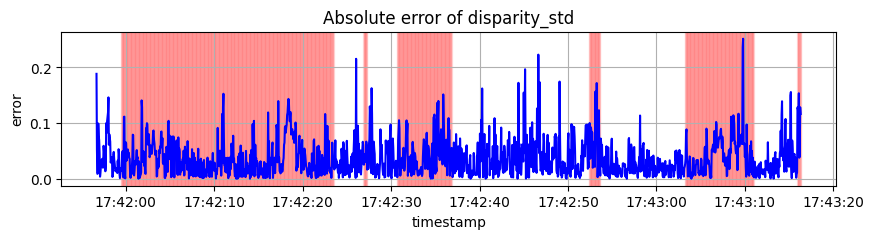

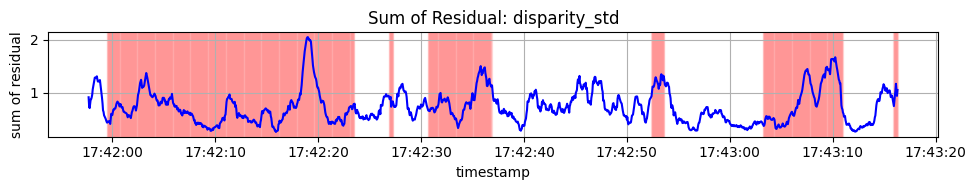

v_x     mse  0.00015469382012061166


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


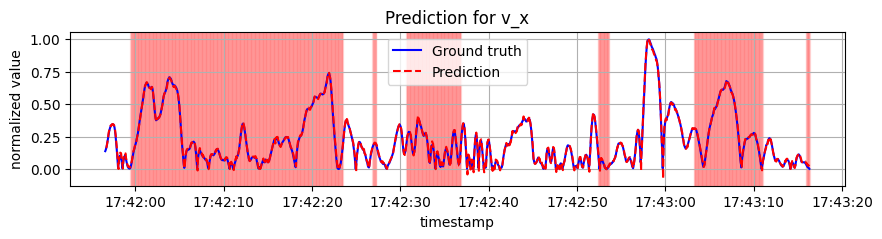

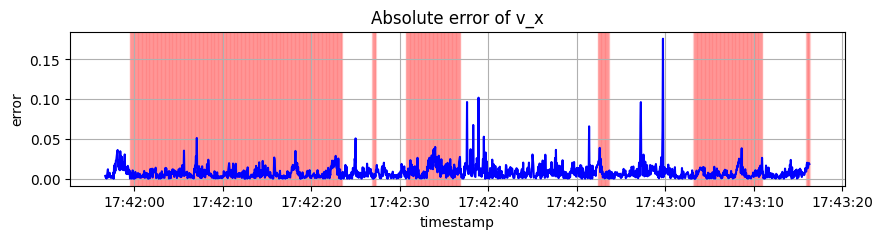

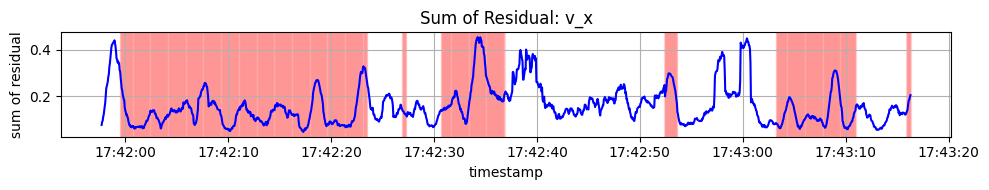

d_vx     mse  0.005230376500698879


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


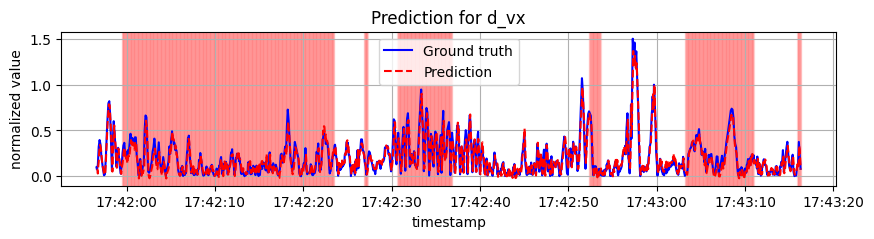

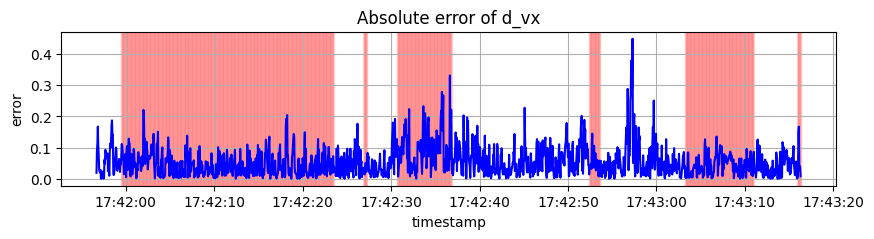

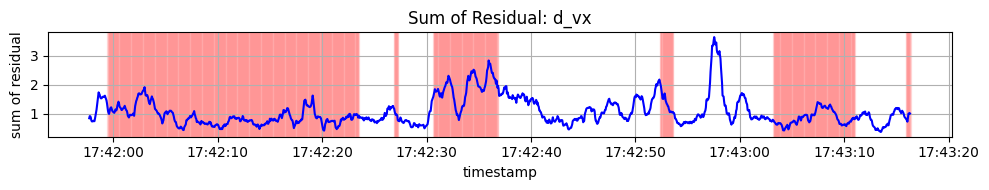

v_y     mse  0.000574002728992928


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


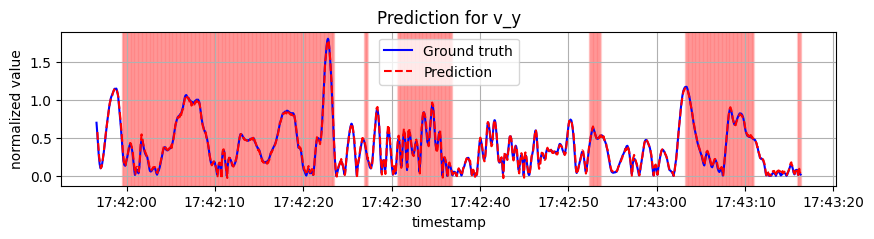

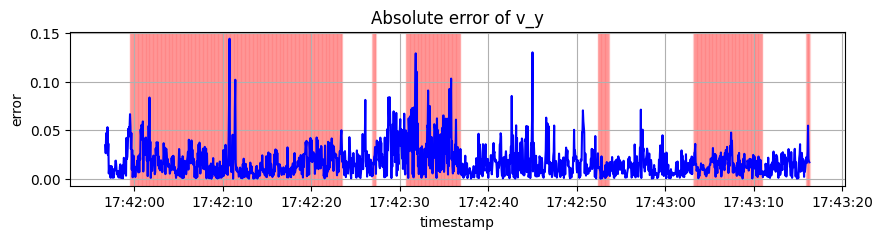

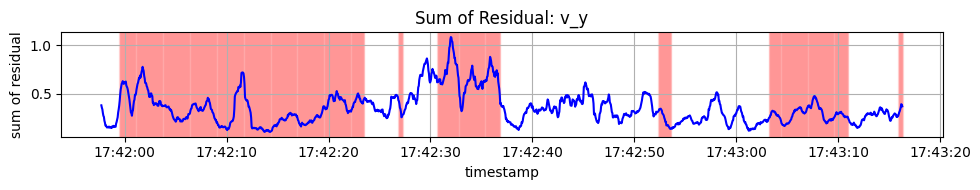

d_vy     mse  0.009936921571976464


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


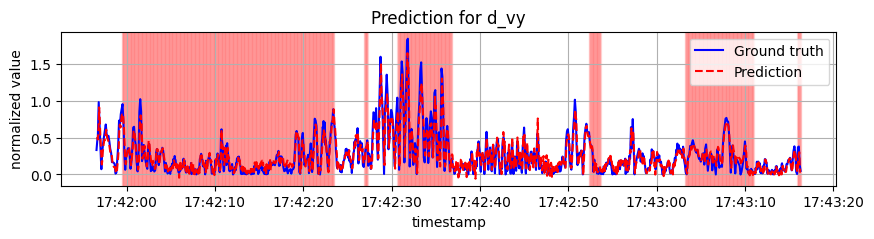

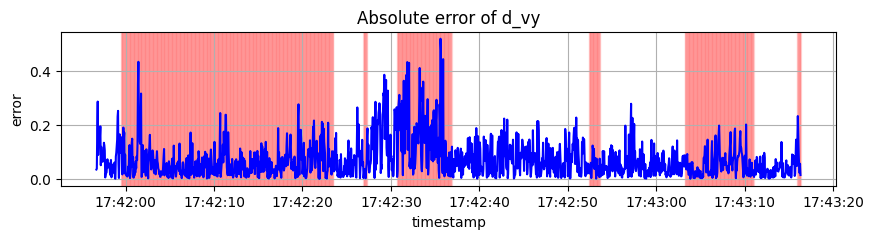

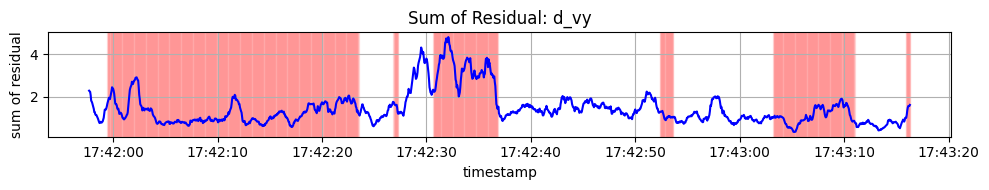

v     mse  0.0001431339330690182


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


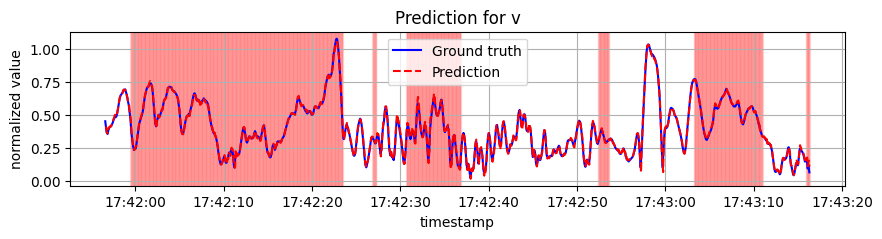

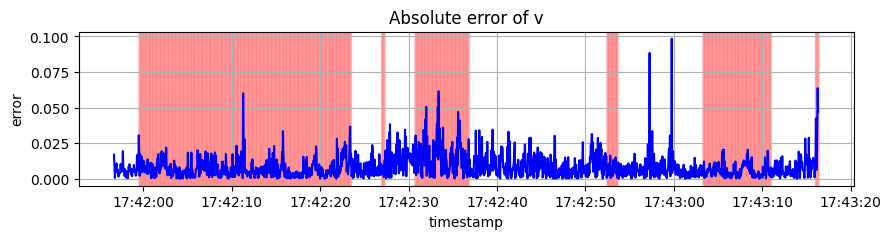

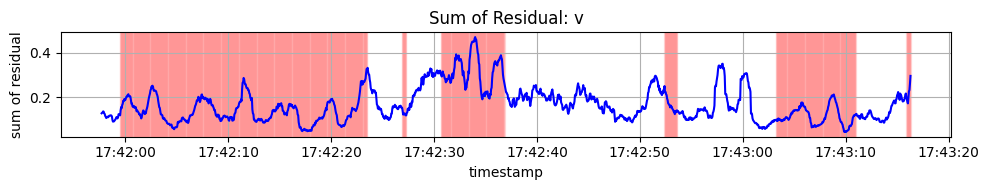

d_v     mse  0.010314105420773712


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


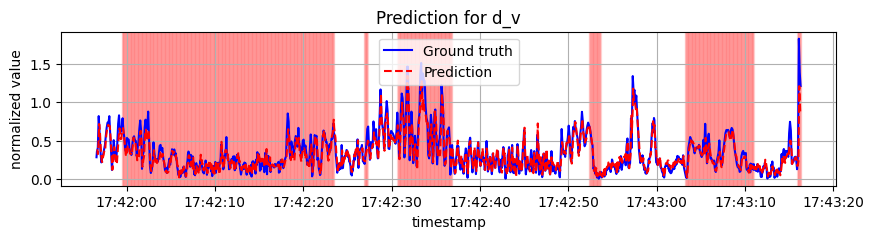

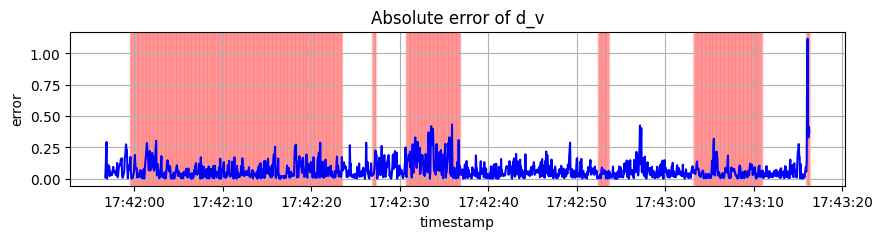

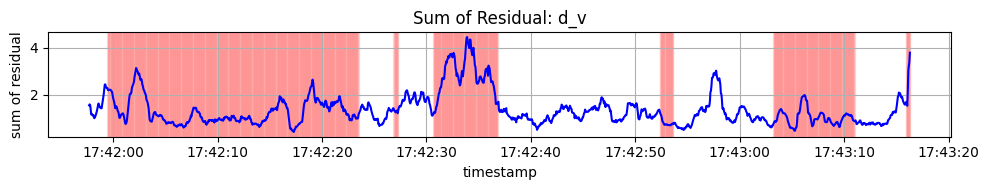

d_wx     mse  0.06862494071815223


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


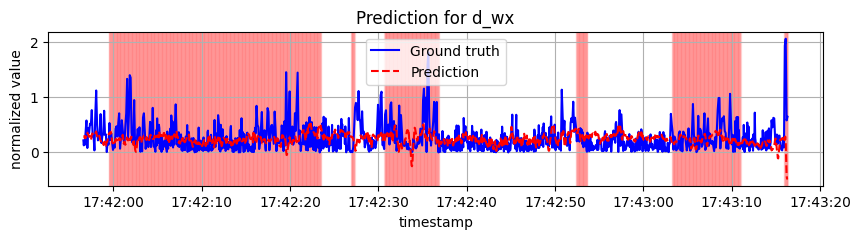

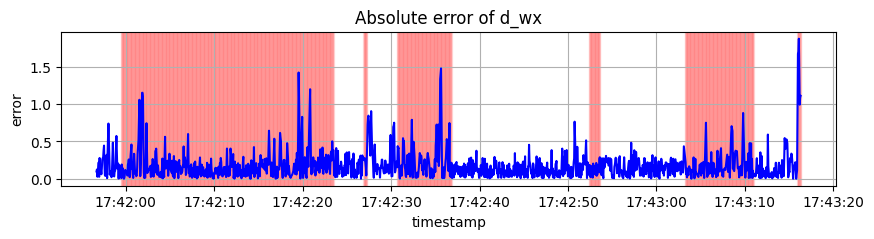

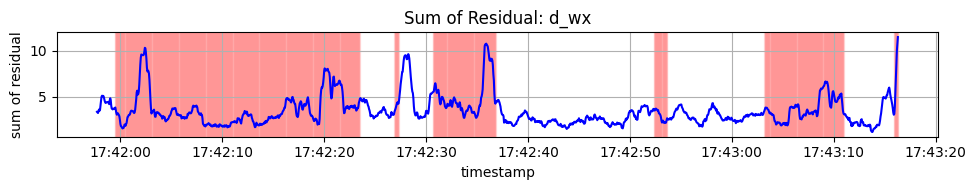

w_y     mse  0.007397388429327272


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


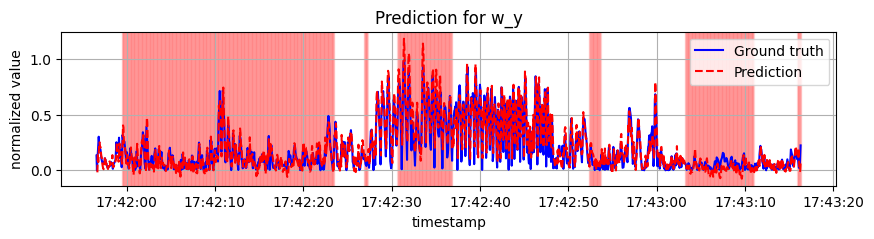

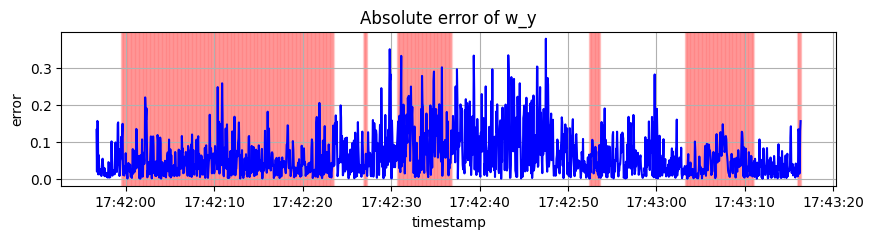

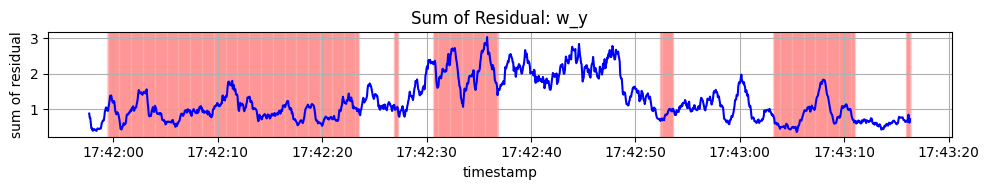

d_wy     mse  0.014037642255193439


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


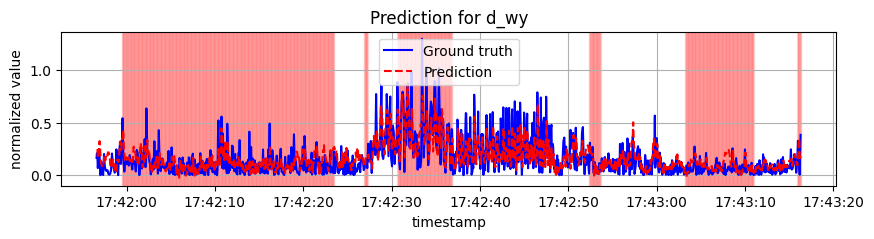

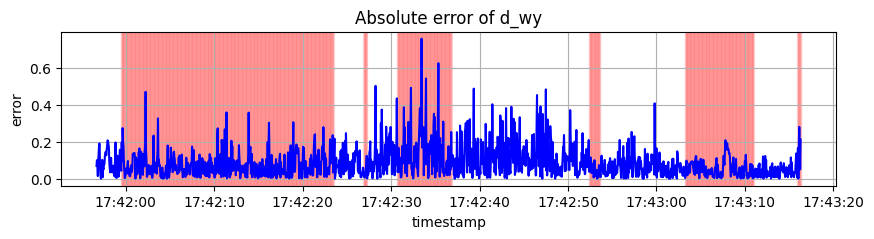

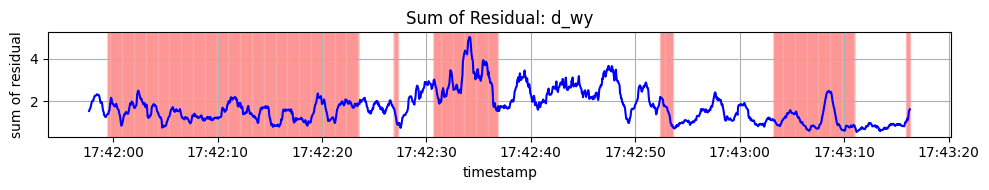

d_wz     mse  0.044447439187359904


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


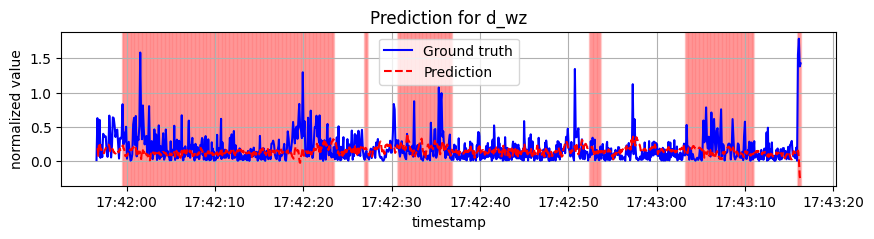

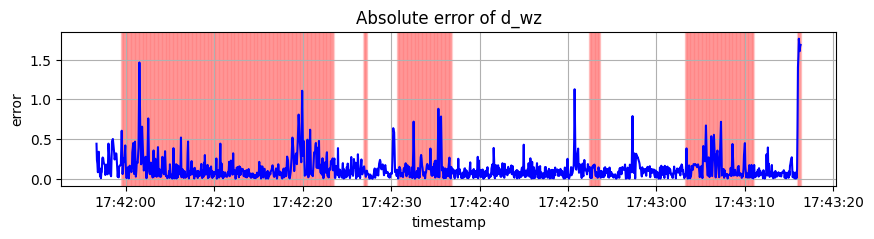

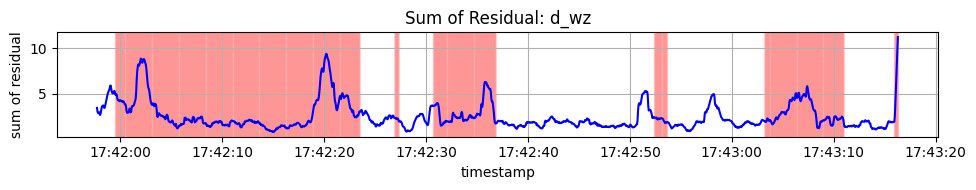

w     mse  0.00509939503842186


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


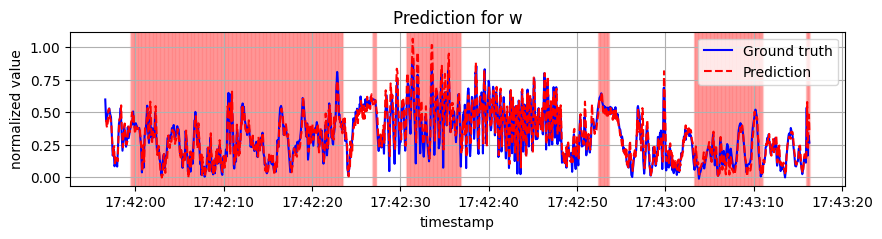

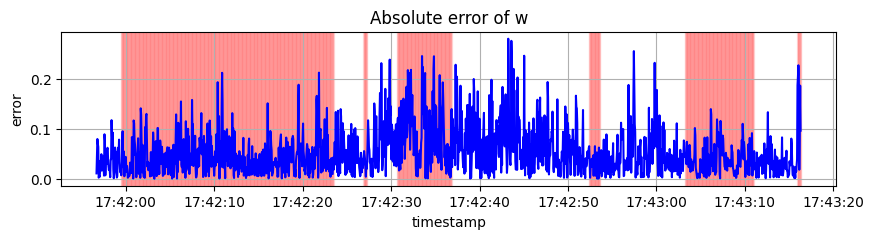

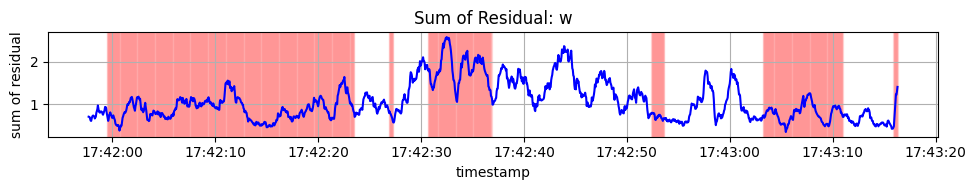

d_w     mse  0.02312426220813459


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:50: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:51: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\3717409880.py:52: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


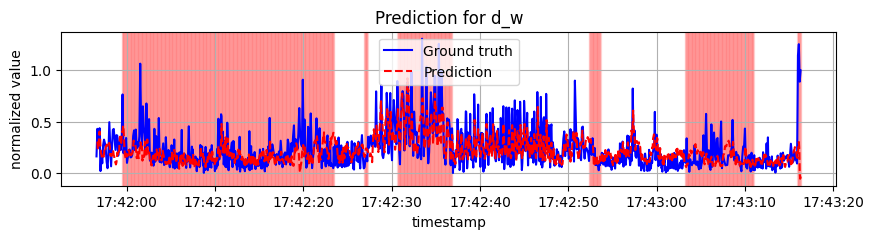

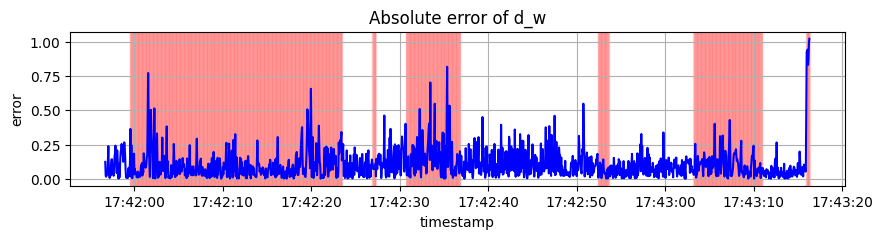

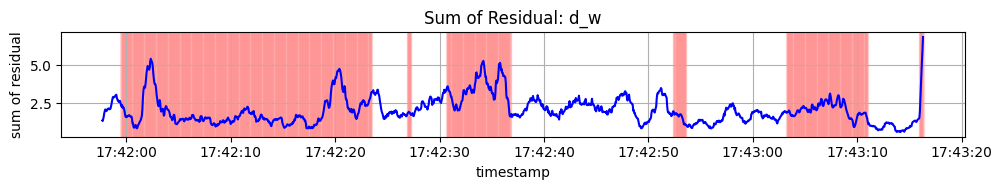

In [24]:
range_val = 20

for i, feature in enumerate(feature_curr):
    y_test=df_test[feature]
    y_pred=df_predicted[feature]

    mse_test = mean_squared_error(y_test[num_lag:], y_pred)
    print(feature,'    mse ',mse_test)

    plt1 = plt.figure(figsize=(10, 2))
    ax1 = plt1.add_subplot(111)

    plt2 = plt.figure(figsize=(10, 2))
    ax2 = plt2.add_subplot(111)

    plt3 = plt.figure(figsize=(10, 2))
    ax3 = plt3.add_subplot(111)
    
    ax1.plot(y_test.index,y_test, label='Ground truth',color='blue')
    ax1.plot(df_predicted.index,y_pred, label='Prediction', linestyle='--',color='red')
    ax1.set_title(feature)
    ax1.grid(True)
    ax1.set_xlabel('timestamp')
    ax1.set_ylabel('normalized value')
    #ax1.legend(loc='lower right')
    ax1.legend()
    ax1.set_title(f'Prediction for {feature}')


    error=np.abs(y_test-y_pred).dropna()
    
    ax2.plot(error.index,error,color='blue')
    ax2.set_title(feature)
    ax2.grid(True)
    ax2.set_xlabel('timestamp')
    ax2.set_ylabel('error')
    ax2.set_title(f'Absolute error of {feature}')

    sum_residual=calculate_residual(error,range_val)
    
    ax3.plot(sum_residual.index,sum_residual,color='blue')
    ax3.set_title(feature)
    ax3.grid(True)
    ax3.set_xlabel('timestamp')
    ax3.set_ylabel('sum of residual')
    ax3.set_title(f'Sum of Residual: {feature}')

    for m, flag in df_test_resampl['success'].items():
        if flag == 0:
            ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()

### Feature set #2

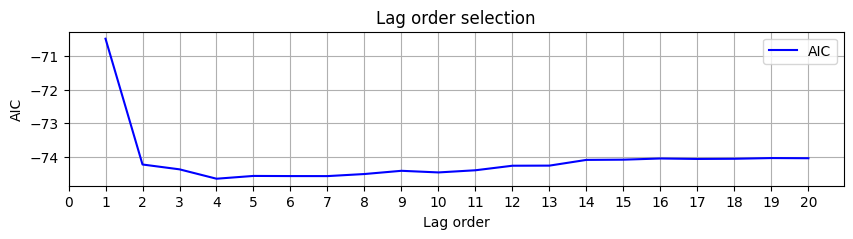

In [25]:
selected_features_2=['laplacian_variance', 'entropy', 'brightness', 'contrast','v_x','d_vx','v_y','d_vy','v','d_v','w','d_w']
feature_curr=selected_features_2
check_optimal_lag(df_train,feature_curr,maxlags = 20)

coeff matrix dimension:    (24, 12)
data matrix dimension:    (1593, 24)


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.11504872 0.07489525 0.17867277 ... 0.28390055 0.17322431 0.1980436 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.74268929 0.6628403  0.80310437 ... 0.74648625 0.7885319  0.78186488]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dt

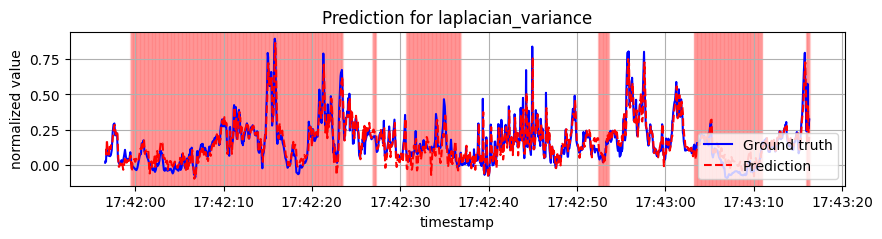

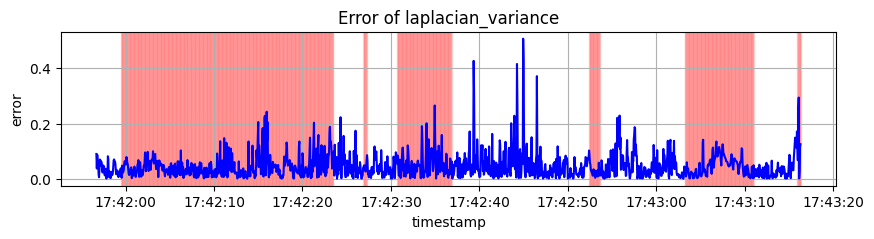

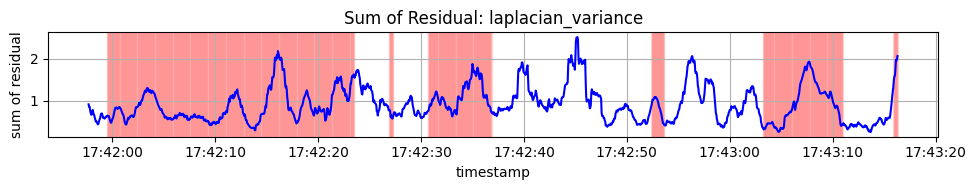

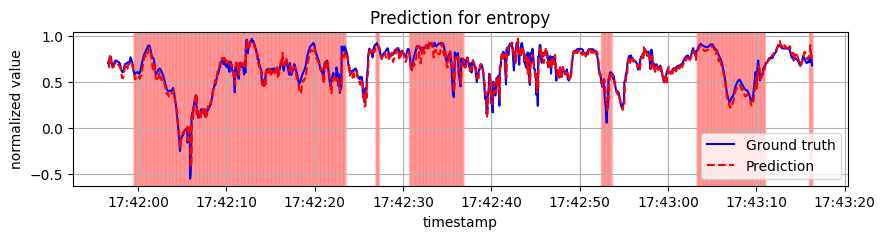

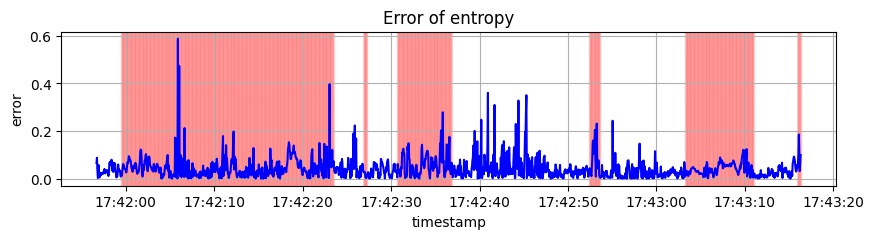

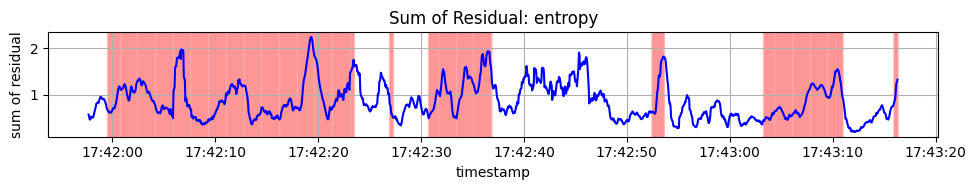

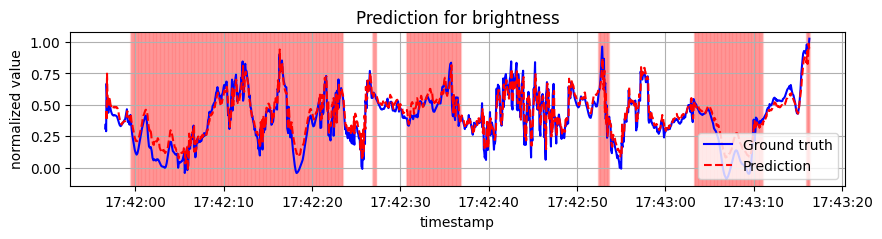

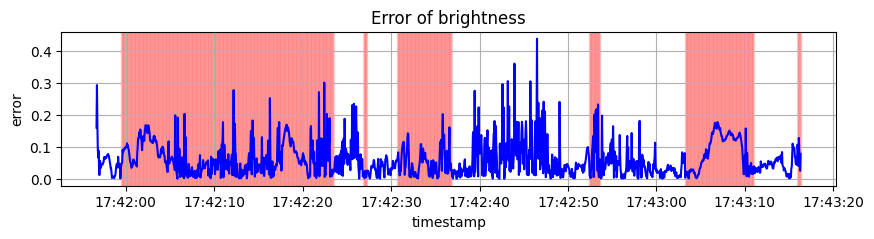

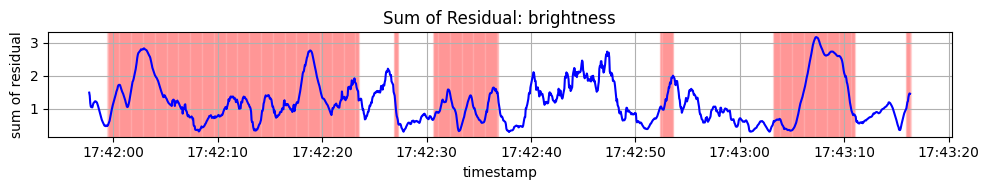

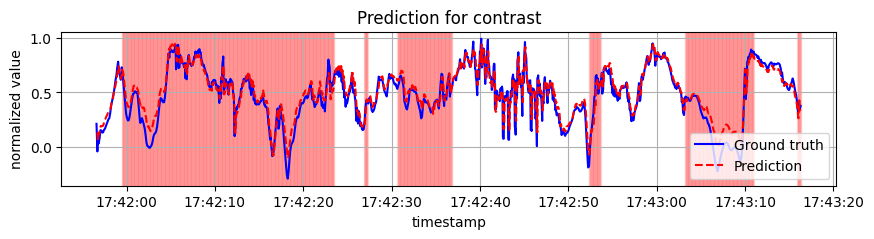

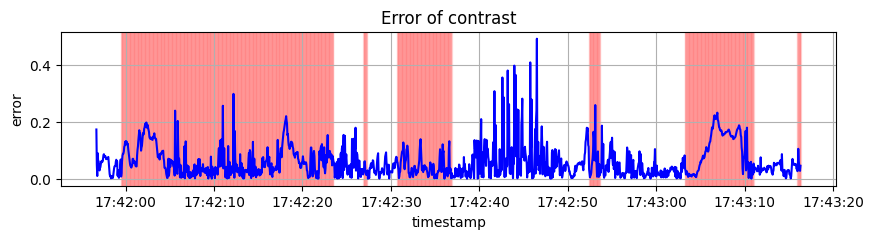

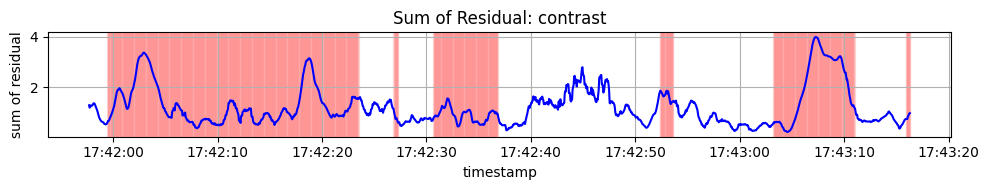

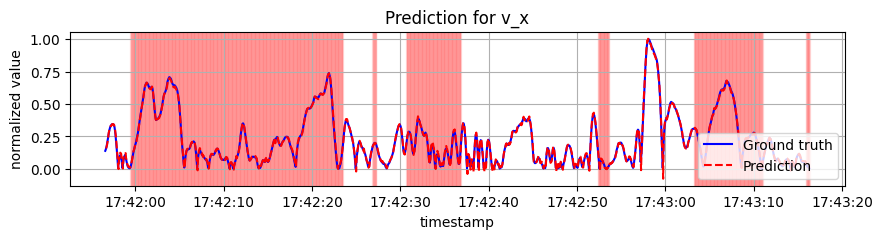

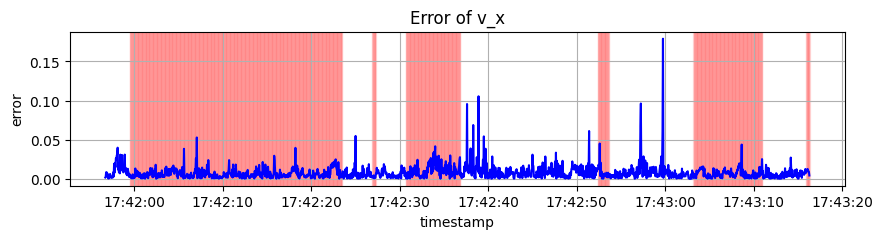

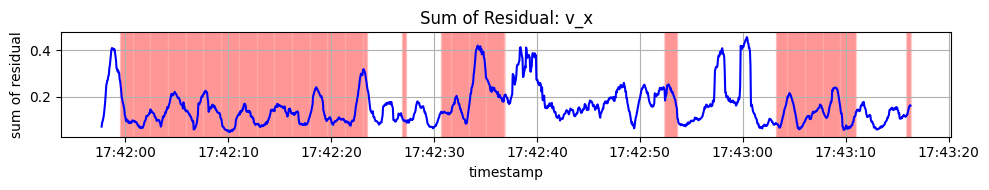

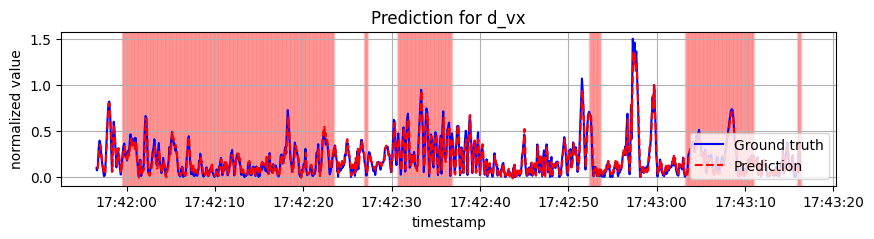

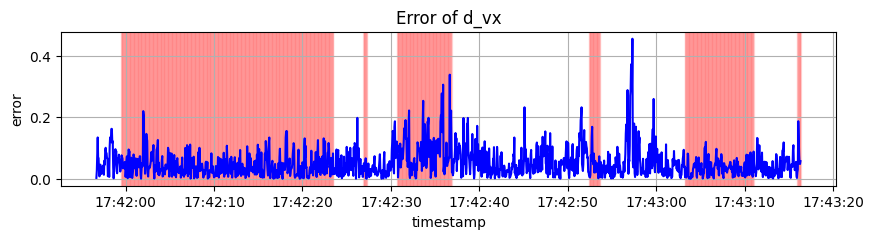

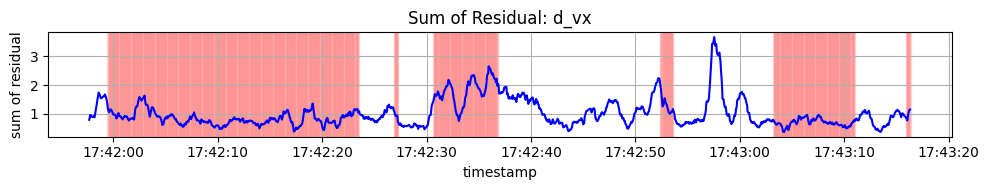

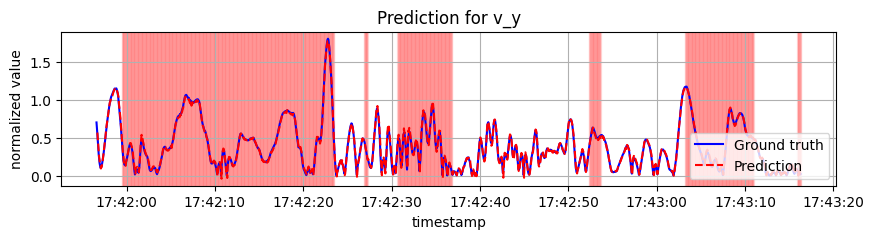

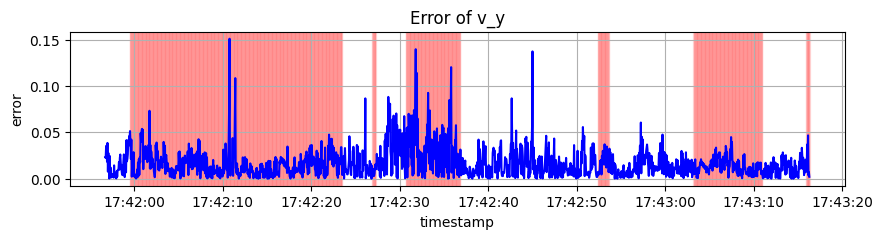

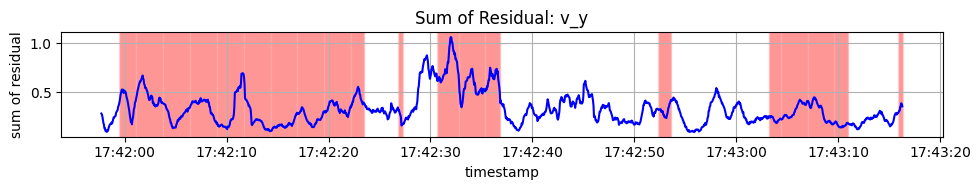

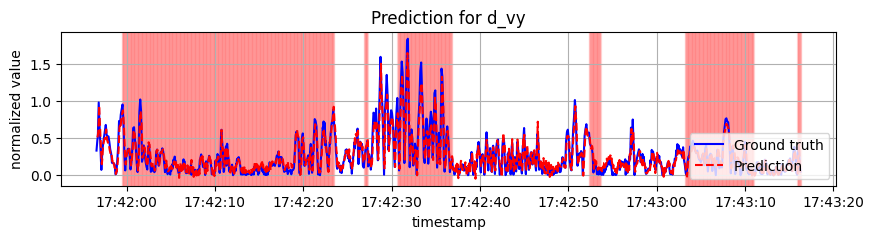

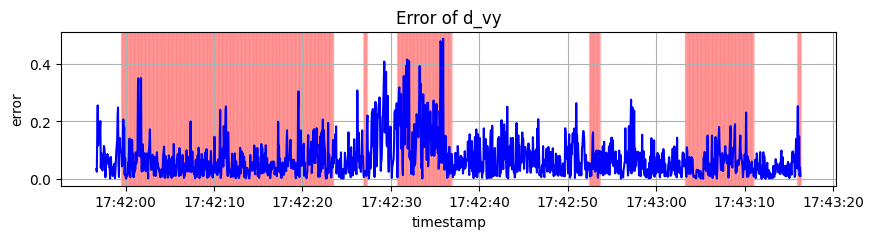

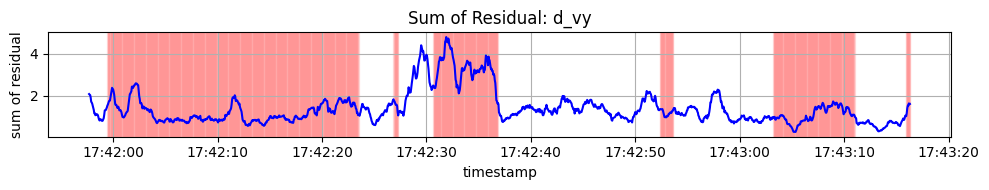

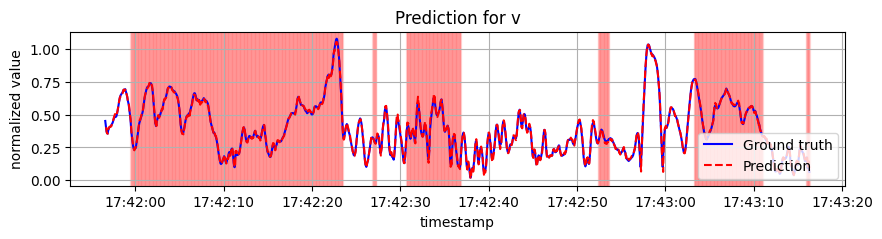

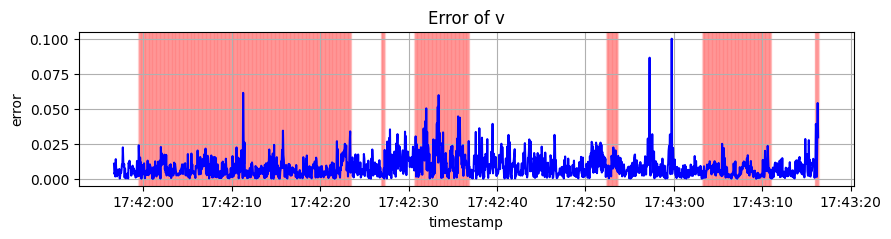

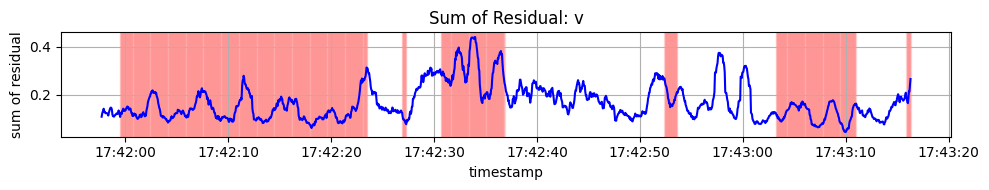

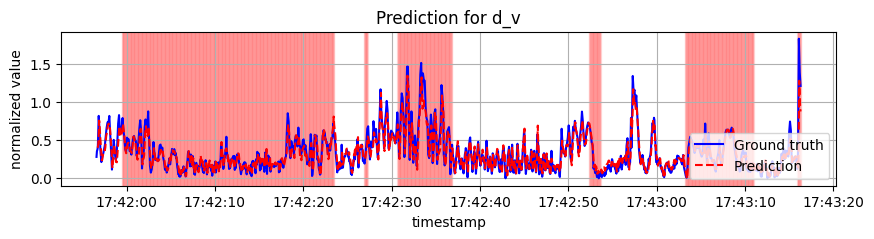

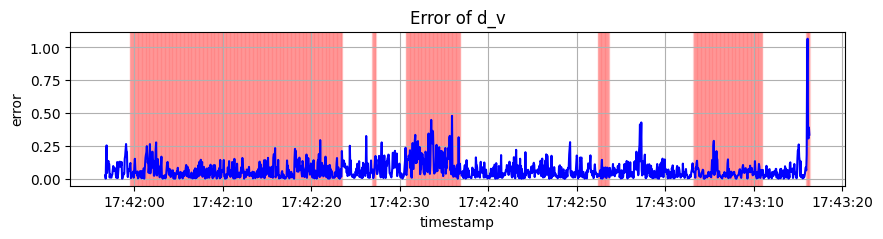

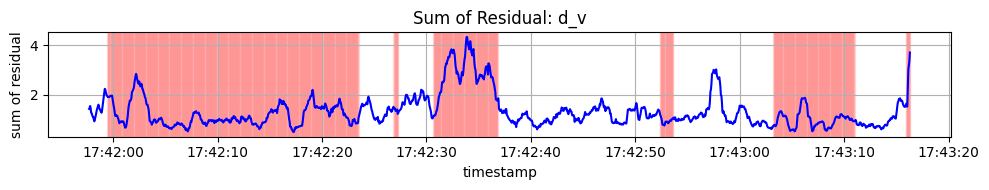

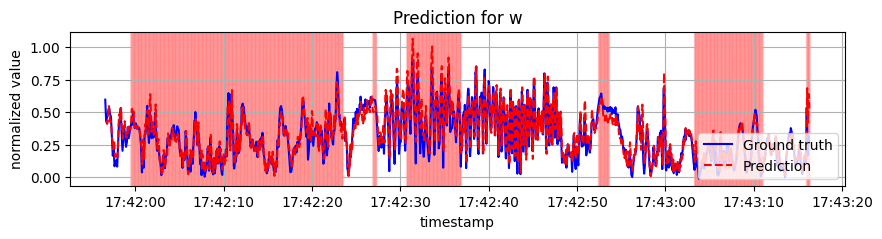

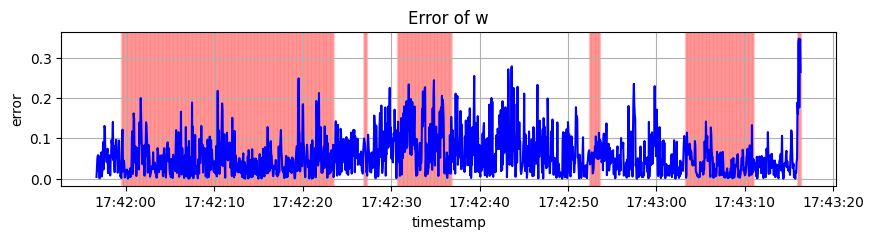

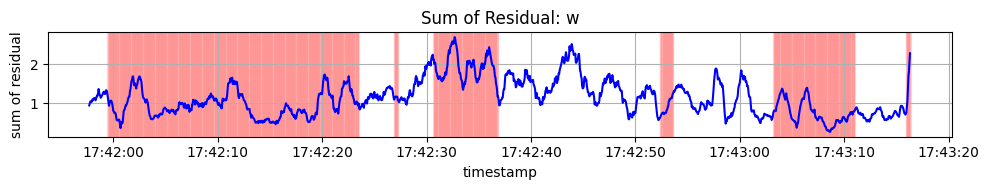

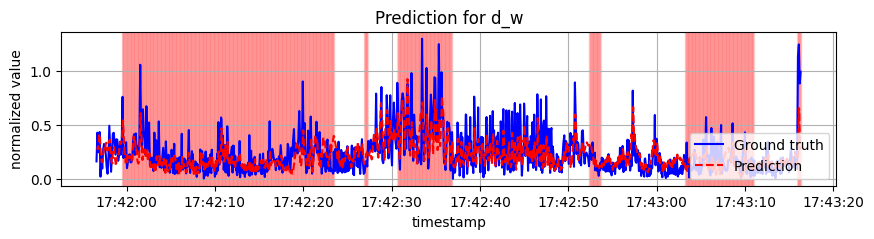

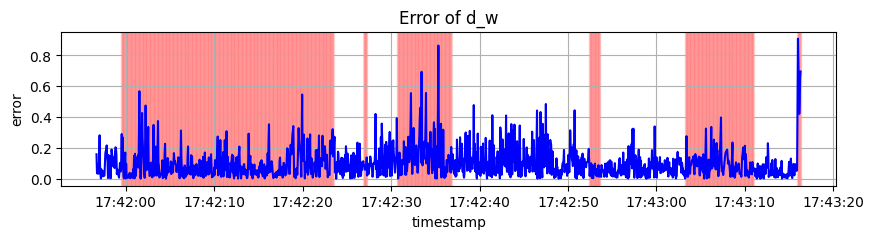

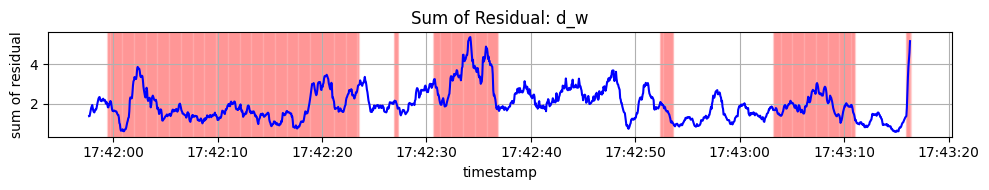

In [26]:
num_lag=2
model_curr=training(df_train,df_test,feature_curr,num_lag)
coeff_mat=form_coeff(model_curr,feature_curr,num_lag)
data_mat=form_data(feature_curr,num_lag)

print("coeff matrix dimension:   ",coeff_mat.shape)
print("data matrix dimension:   ",data_mat.shape)

multi_mat=np.matmul(data_mat,coeff_mat)
predicted_mat=multi_mat+model_curr.intercept

predicted_df_bf = pd.DataFrame(predicted_mat)

df_predicted = pd.DataFrame(0, index=df_test.index,columns=feature_curr)
df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
df_predicted=df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :]

range_val = 20

for i, feature in enumerate(feature_curr):
    y_test=df_test[feature]
    y_pred=df_predicted[feature]

    plt1 = plt.figure(figsize=(10, 2))
    ax1 = plt1.add_subplot(111)

    plt2 = plt.figure(figsize=(10, 2))
    ax2 = plt2.add_subplot(111)

    plt3 = plt.figure(figsize=(10, 2))
    ax3 = plt3.add_subplot(111)
    
    ax1.plot(y_test.index,y_test, label='Ground truth',color='blue')
    ax1.plot(df_predicted.index,y_pred, label='Prediction', linestyle='--',color='red')
    ax1.set_title(feature)
    ax1.grid(True)
    ax1.set_xlabel('timestamp')
    ax1.set_ylabel('normalized value')
    ax1.legend(loc='lower right')
    ax1.set_title(f'Prediction for {feature}')

    error=np.abs(y_test-y_pred).dropna()
    
    ax2.plot(error.index,error,color='blue')
    ax2.set_title(feature)
    ax2.grid(True)
    ax2.set_xlabel('timestamp')
    ax2.set_ylabel('error')
    ax2.set_title(f'Error of {feature}')

    sum_residual=calculate_residual(error,range_val)
    
    ax3.plot(sum_residual.index,sum_residual,color='blue')
    ax3.set_title(feature)
    ax3.grid(True)
    ax3.set_xlabel('timestamp')
    ax3.set_ylabel('sum of residual')
    ax3.set_title(f'Sum of Residual: {feature}')

    for m, flag in df_test_resampl['success'].items():
        if flag == 0:
            ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()

### Feature set #3

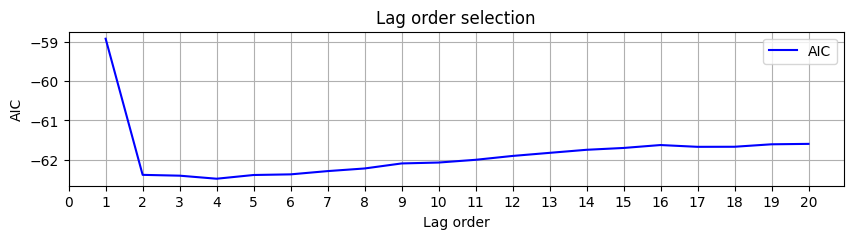

In [27]:
selected_features_3=['laplacian_variance', 'contrast','v_x','d_vx','v_y','d_vy','v','d_v','w','d_w']
feature_curr=selected_features_3
check_optimal_lag(df_train,feature_curr,maxlags = 20)

coeff matrix dimension:    (20, 10)
data matrix dimension:    (1593, 20)


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.08051166 0.05637039 0.12742583 ... 0.27679447 0.1680813  0.19881193]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.10820332 0.008431   0.13844691 ... 0.44177237 0.40342608 0.40972776]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dt

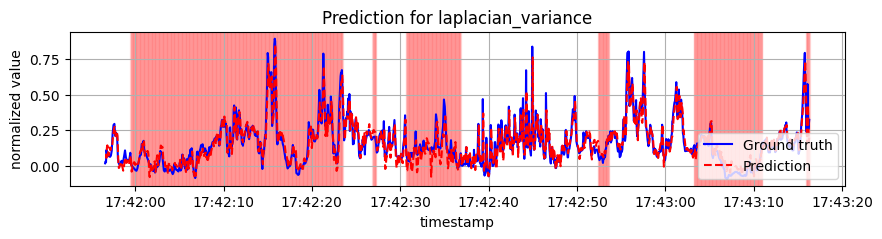

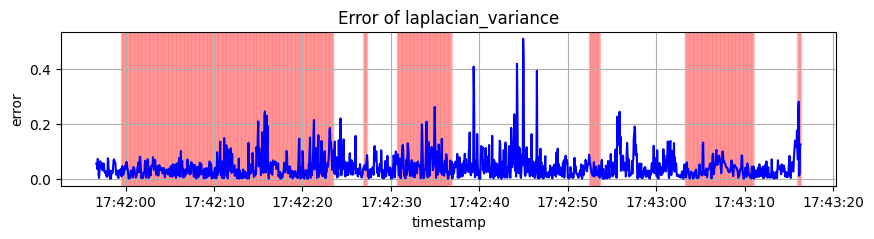

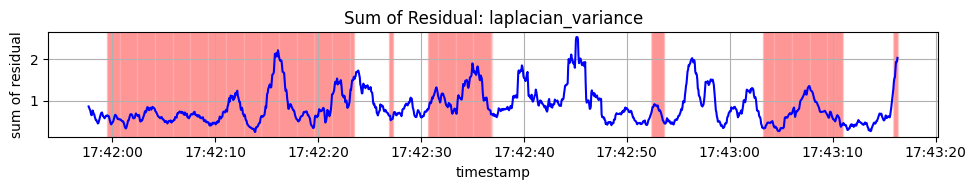

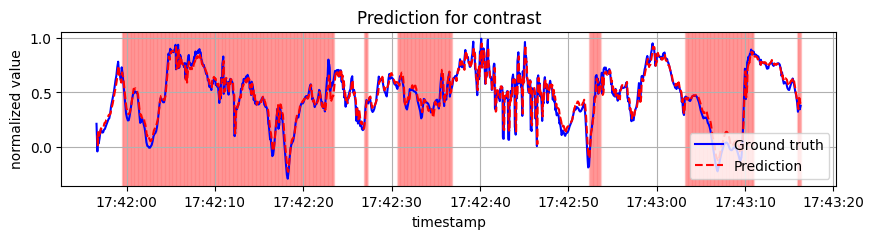

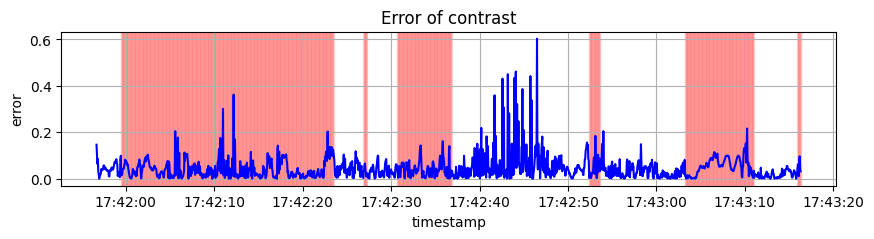

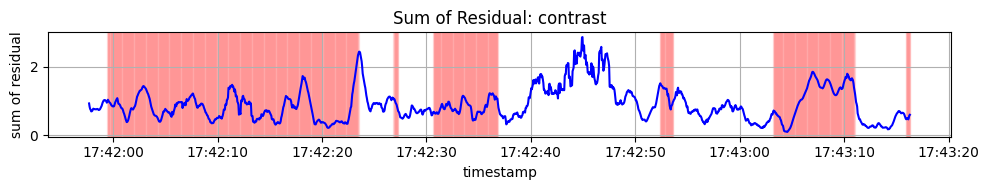

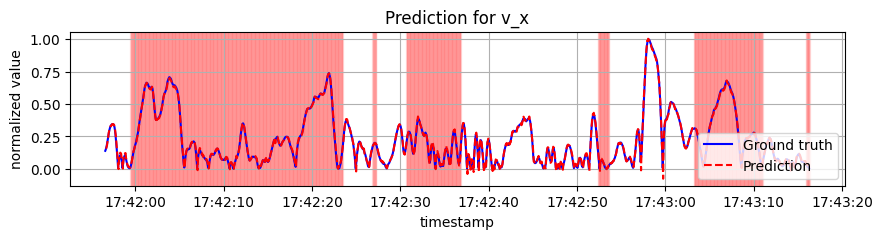

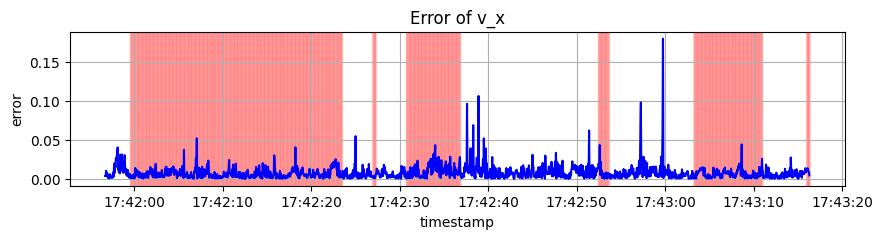

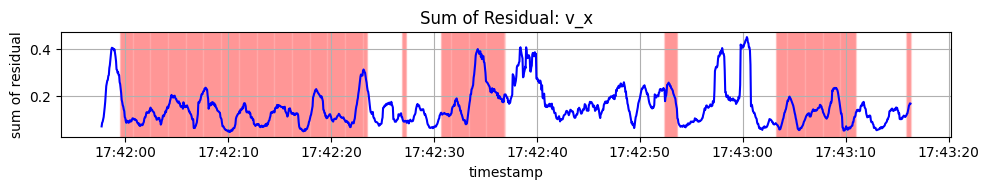

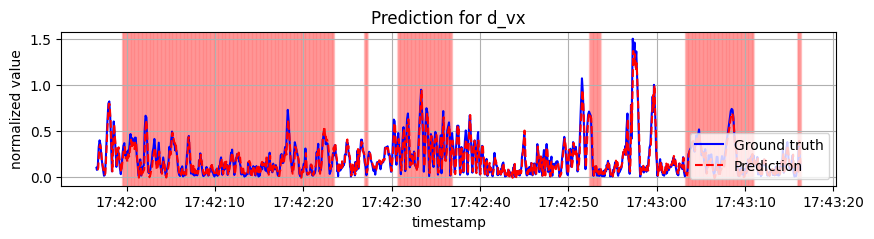

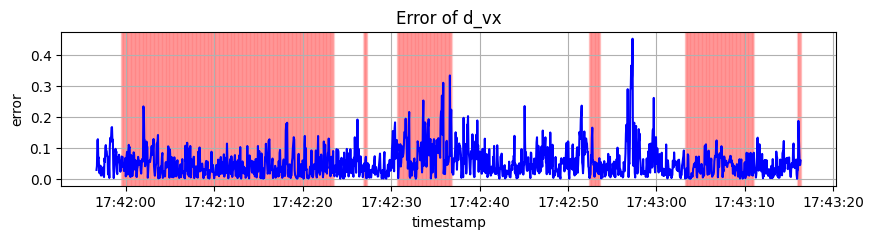

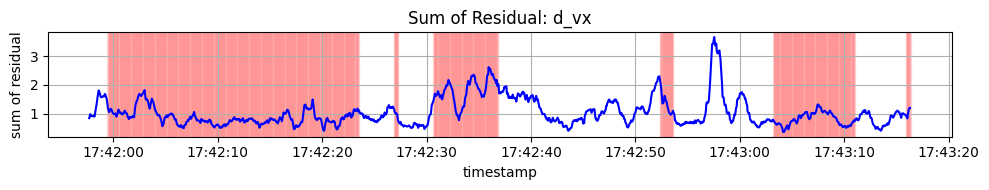

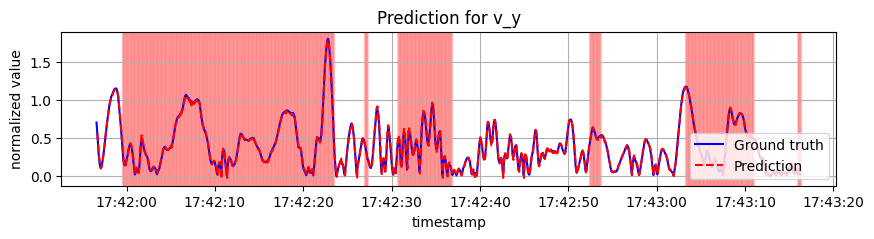

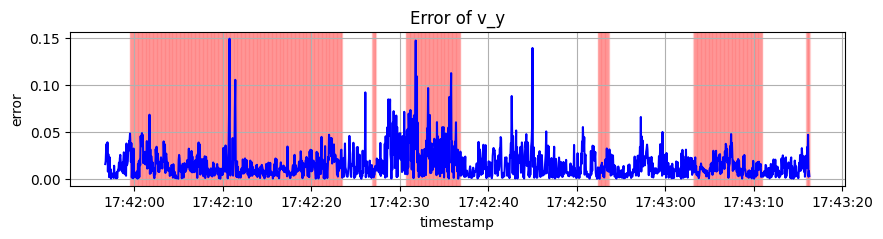

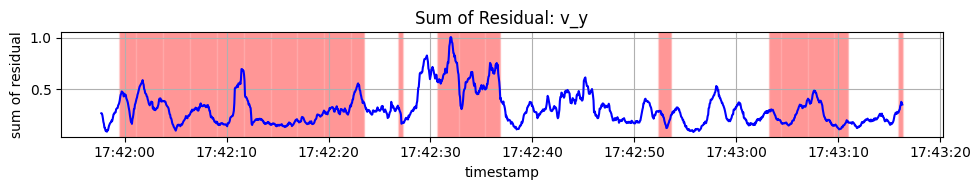

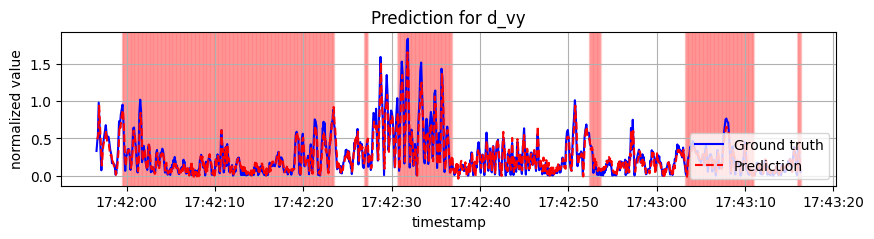

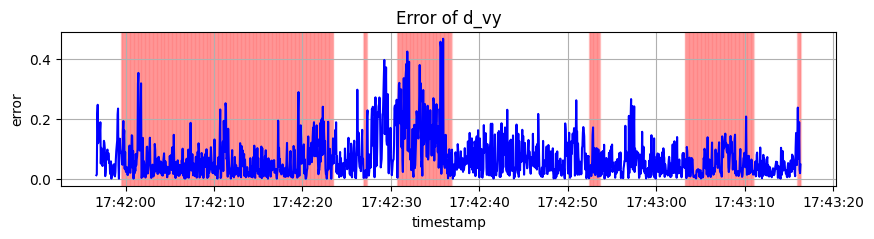

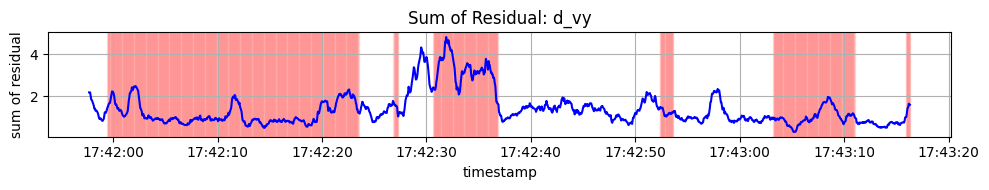

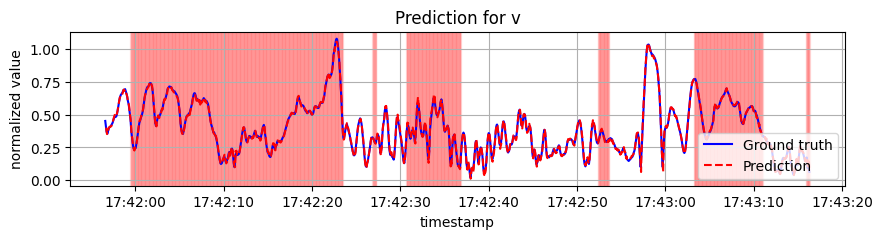

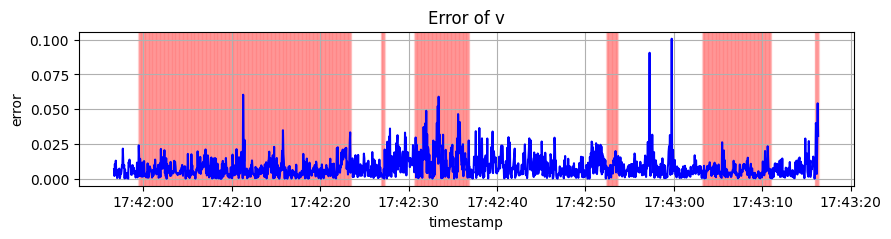

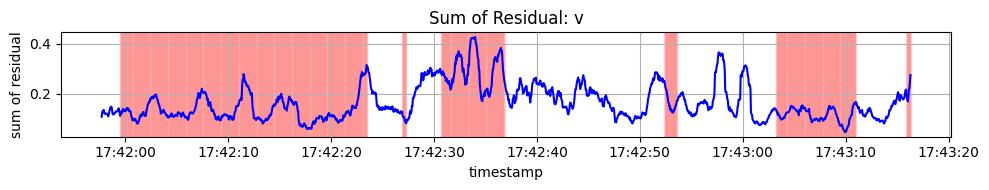

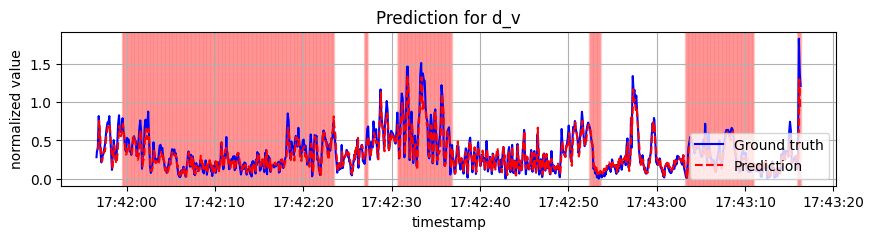

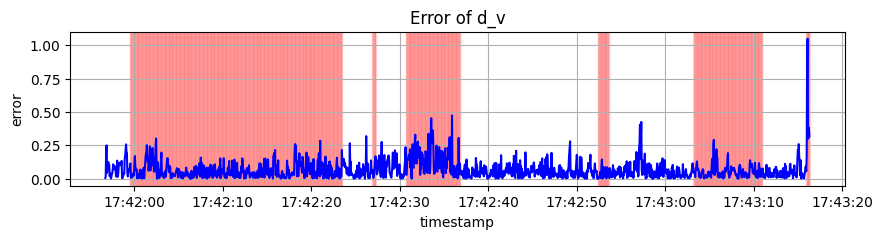

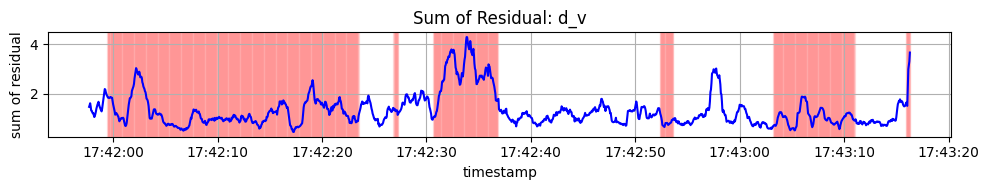

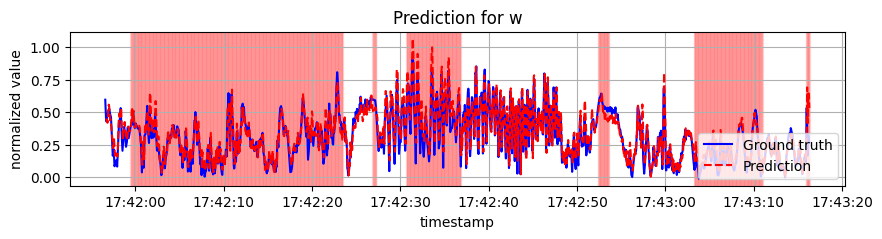

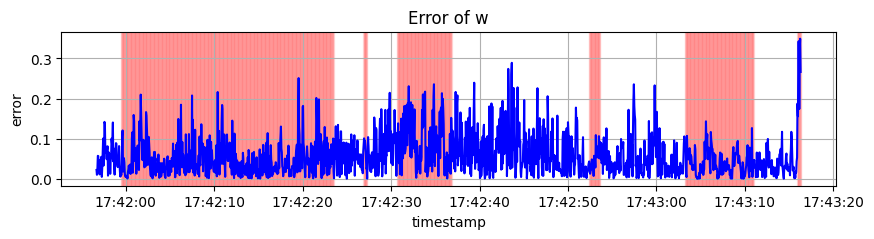

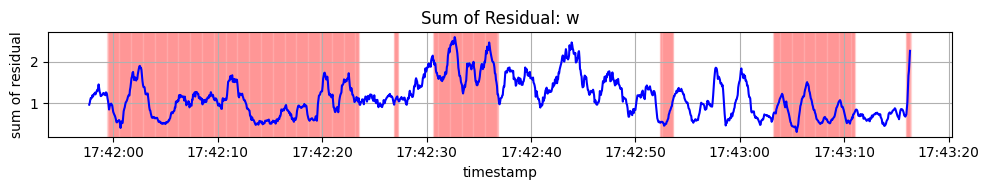

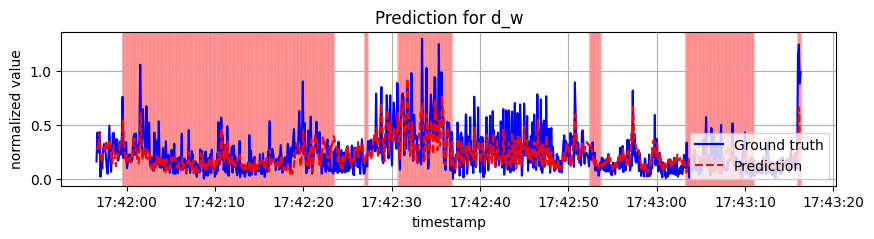

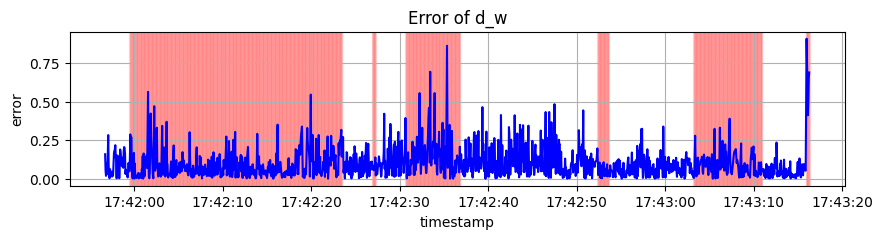

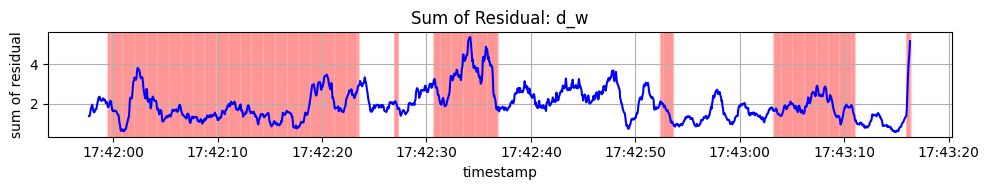

In [28]:
num_lag=2
model_curr=training(df_train,df_test,feature_curr,num_lag)
coeff_mat=form_coeff(model_curr,feature_curr,num_lag)
data_mat=form_data(feature_curr,num_lag)

print("coeff matrix dimension:   ",coeff_mat.shape)
print("data matrix dimension:   ",data_mat.shape)

multi_mat=np.matmul(data_mat,coeff_mat)
predicted_mat=multi_mat+model_curr.intercept

predicted_df_bf = pd.DataFrame(predicted_mat)

df_predicted = pd.DataFrame(0, index=df_test.index,columns=feature_curr)
df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
df_predicted=df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :]

range_val = 20

for i, feature in enumerate(feature_curr):
    y_test=df_test[feature]
    y_pred=df_predicted[feature]

    plt1 = plt.figure(figsize=(10, 2))
    ax1 = plt1.add_subplot(111)

    plt2 = plt.figure(figsize=(10, 2))
    ax2 = plt2.add_subplot(111)

    plt3 = plt.figure(figsize=(10, 2))
    ax3 = plt3.add_subplot(111)
    
    ax1.plot(y_test.index,y_test, label='Ground truth',color='blue')
    ax1.plot(df_predicted.index,y_pred, label='Prediction', linestyle='--',color='red')
    ax1.set_title(feature)
    ax1.grid(True)
    ax1.set_xlabel('timestamp')
    ax1.set_ylabel('normalized value')
    ax1.legend(loc='lower right')
    ax1.set_title(f'Prediction for {feature}')

    error=np.abs(y_test-y_pred).dropna()
    
    ax2.plot(error.index,error,color='blue')
    ax2.set_title(feature)
    ax2.grid(True)
    ax2.set_xlabel('timestamp')
    ax2.set_ylabel('error')
    ax2.set_title(f'Error of {feature}')

    sum_residual=calculate_residual(error,range_val)
    
    ax3.plot(sum_residual.index,sum_residual,color='blue')
    ax3.set_title(feature)
    ax3.grid(True)
    ax3.set_xlabel('timestamp')
    ax3.set_ylabel('sum of residual')
    ax3.set_title(f'Sum of Residual: {feature}')

    for m, flag in df_test_resampl['success'].items():
        if flag == 0:
            ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()

### Feature set #4

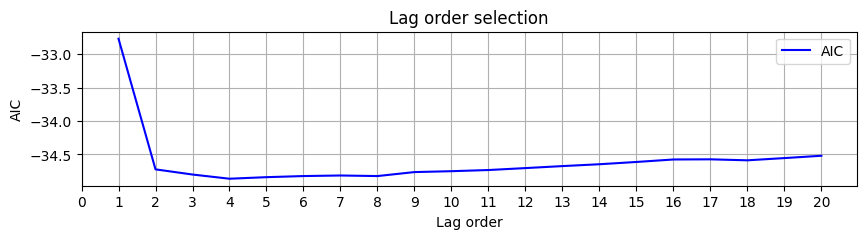

In [29]:
selected_features_4=['laplacian_variance', 'contrast','v','d_v','w','d_w']
feature_curr=selected_features_4
check_optimal_lag(df_train,feature_curr,maxlags = 20)

coeff matrix dimension:    (12, 6)
data matrix dimension:    (1593, 12)


C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.09070183 0.06461141 0.13103848 ... 0.2612553  0.14876553 0.18791134]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.11946211 0.02144473 0.15059988 ... 0.44526379 0.40904626 0.41901681]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_6464\2233504137.py:15: FutureWarning: Setting an item of incompatible dt

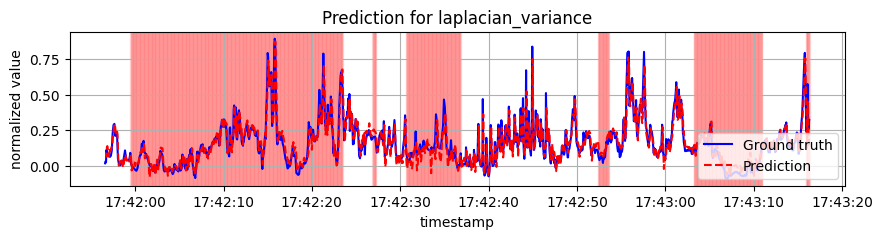

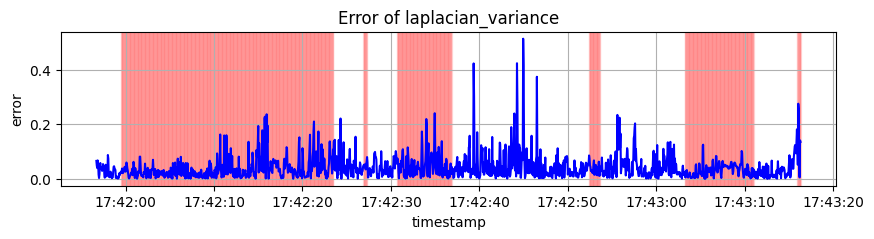

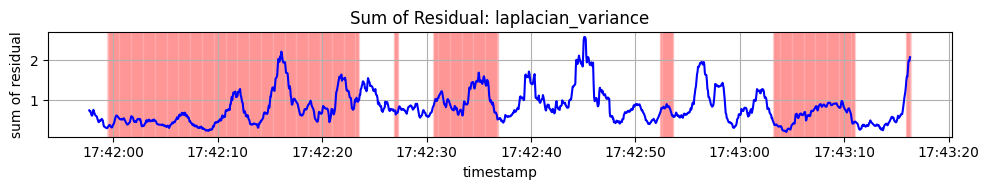

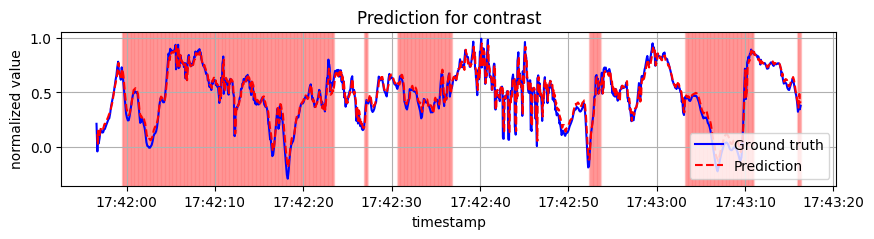

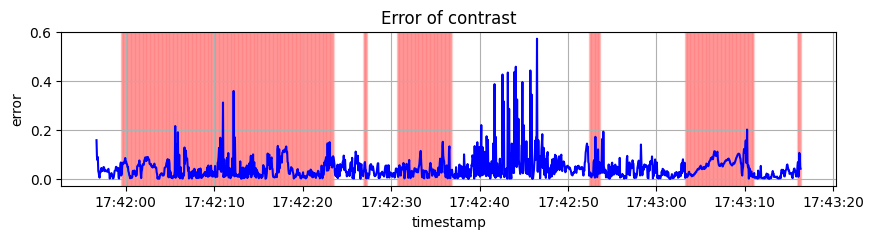

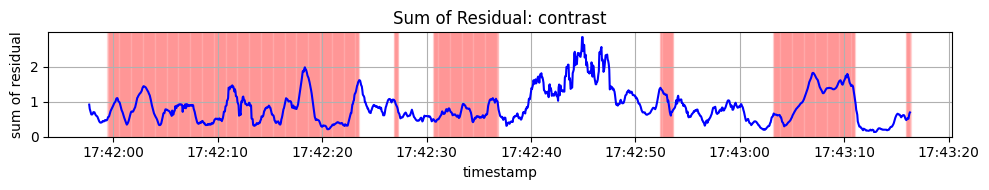

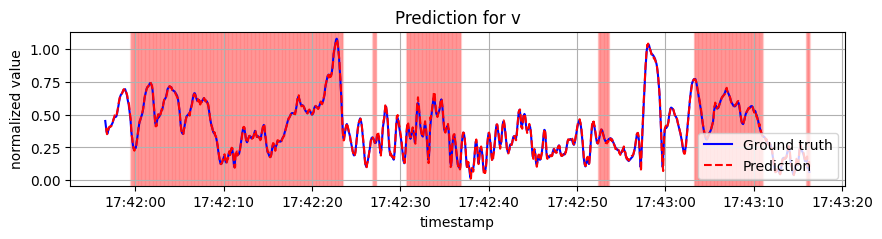

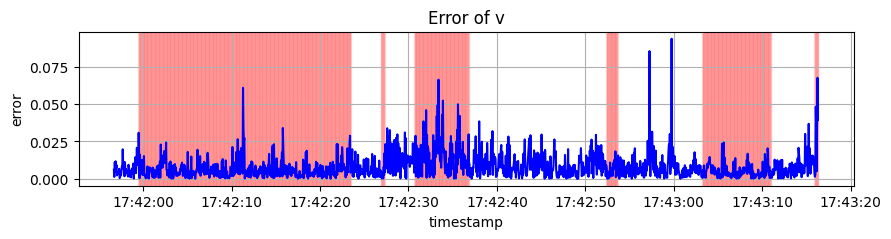

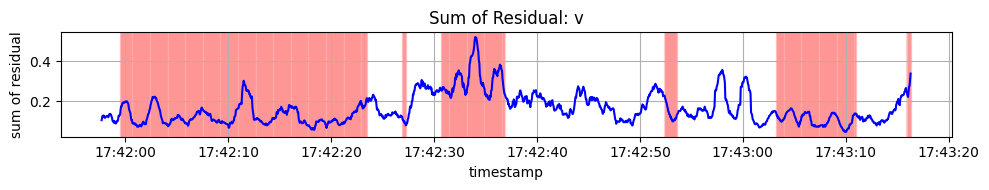

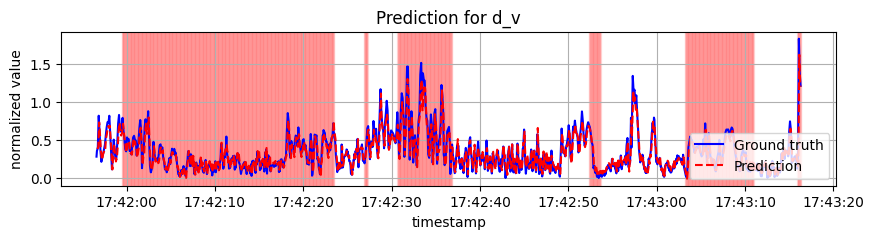

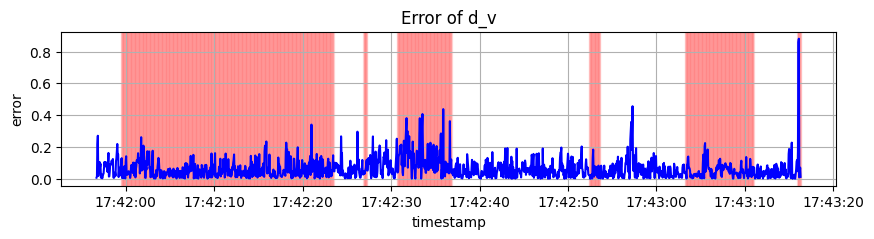

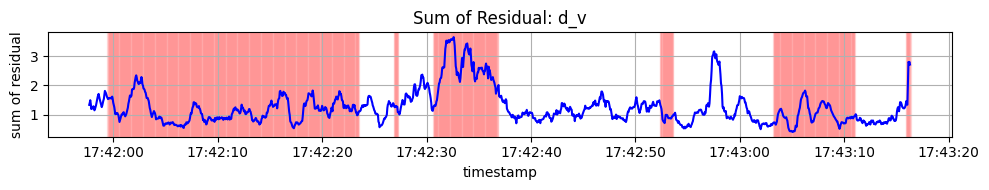

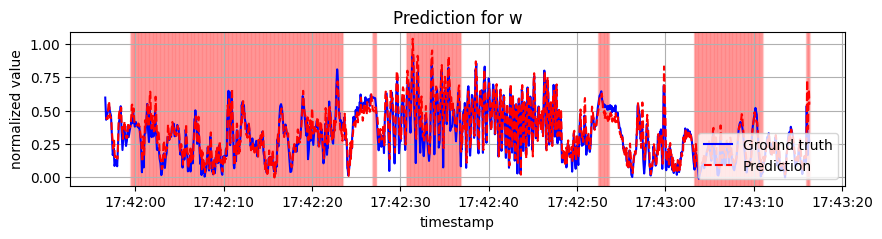

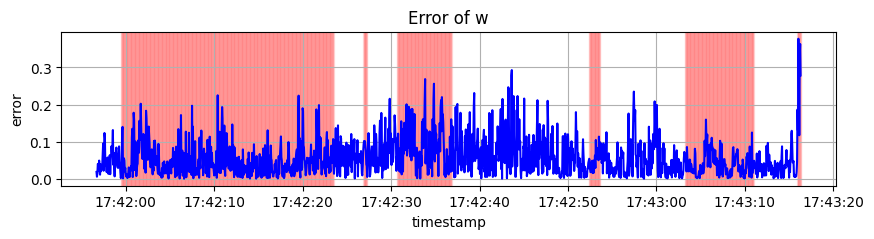

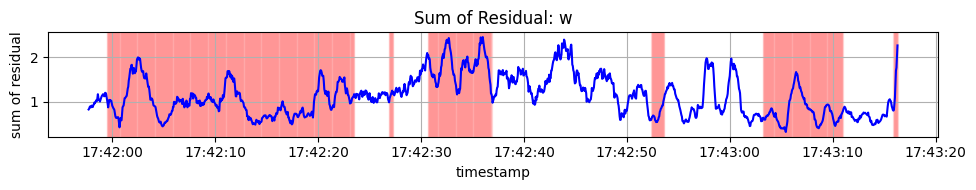

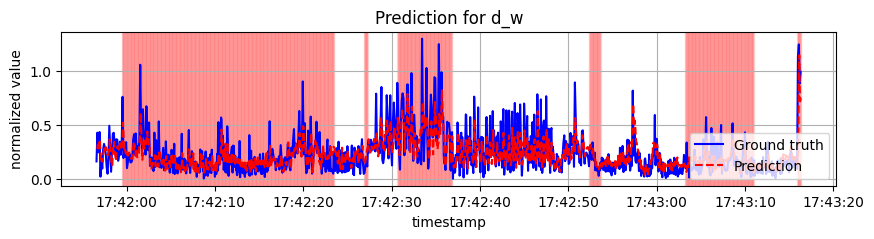

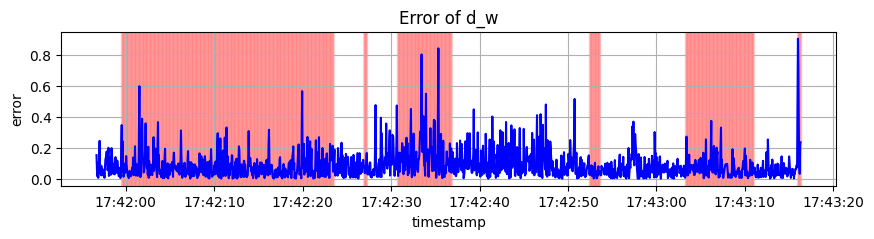

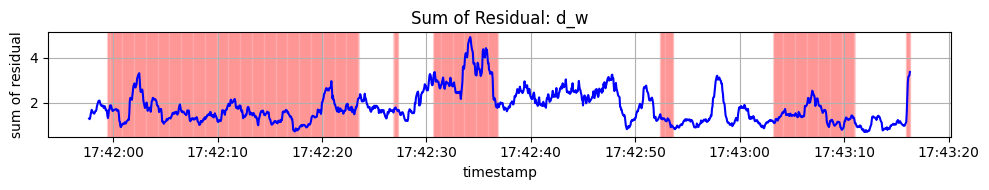

In [30]:
num_lag=2
model_curr=training(df_train,df_test,feature_curr,num_lag)
coeff_mat=form_coeff(model_curr,feature_curr,num_lag)
data_mat=form_data(feature_curr,num_lag)

print("coeff matrix dimension:   ",coeff_mat.shape)
print("data matrix dimension:   ",data_mat.shape)

multi_mat=np.matmul(data_mat,coeff_mat)
predicted_mat=multi_mat+model_curr.intercept

predicted_df_bf = pd.DataFrame(predicted_mat)

df_predicted = pd.DataFrame(0, index=df_test.index,columns=feature_curr)
df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :] = predicted_df_bf.values
df_predicted=df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf), :]

range_val = 20

for i, feature in enumerate(feature_curr):
    y_test=df_test[feature]
    y_pred=df_predicted[feature]

    plt1 = plt.figure(figsize=(10, 2))
    ax1 = plt1.add_subplot(111)

    plt2 = plt.figure(figsize=(10, 2))
    ax2 = plt2.add_subplot(111)

    plt3 = plt.figure(figsize=(10, 2))
    ax3 = plt3.add_subplot(111)
    
    ax1.plot(y_test.index,y_test, label='Ground truth',color='blue')
    ax1.plot(df_predicted.index,y_pred, label='Prediction', linestyle='--',color='red')
    ax1.set_title(feature)
    ax1.grid(True)
    ax1.set_xlabel('timestamp')
    ax1.set_ylabel('normalized value')
    ax1.legend(loc='lower right')
    ax1.set_title(f'Prediction for {feature}')

    error=np.abs(y_test-y_pred).dropna()
    
    ax2.plot(error.index,error,color='blue')
    ax2.set_title(feature)
    ax2.grid(True)
    ax2.set_xlabel('timestamp')
    ax2.set_ylabel('error')
    ax2.set_title(f'Error of {feature}')

    sum_residual=calculate_residual(error,range_val)
    
    ax3.plot(sum_residual.index,sum_residual,color='blue')
    ax3.set_title(feature)
    ax3.grid(True)
    ax3.set_xlabel('timestamp')
    ax3.set_ylabel('sum of residual')
    ax3.set_title(f'Sum of Residual: {feature}')

    for m, flag in df_test_resampl['success'].items():
        if flag == 0:
            ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()